In [1]:
# This should be called before numpy is imported.
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
import warnings
warnings.filterwarnings(action = 'ignore')
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Preprocessing

In [5]:
games = pd.read_json('output/RPGproducts.json')

In [6]:
games

name  \
0                                 Karpov   
1                             Holy Catch   
2                    Sakura Kanji Ketchi   
3      Mechaneer Resta's Grand Adventure   
4      Adventures of Skye the Slime Maid   
...                                  ...   
10011                       Takara Cards   
10012             The Ship: Murder Party   
10013                        Bakeborough   
10014          赌神模拟器：亚洲风云God Of Gamblers   
10015             Geneforge 4: Rebellion   

                                                    tags  num_reviews  \
0      [RPG, Visual Novel, Simulation, Horror, Multip...          1.0   
1      [Adventure, RPG, Action-Adventure, Action RPG,...          NaN   
2      [Casual, RPG, Action RPG, Education, Trivia, 2...          NaN   
3      [Adventure, RPG, JRPG, 2D, Singleplayer, Anime...         19.0   
4      [Casual, RPG, Visual Novel, Anime, Colorful, T...          0.0   
...                                                  ...          ...   
10011  [Early Access, Turn-Based Tactics, Roguelite, ...         19.0   
10012  [Multiplayer, Indie, First-Person, Action, Ste...       2538.0   
10013  [Indie, Adventure, Pixel Graphics, Colorful, C...          1.0   
10014  [Sexual Content, Nudity, Mature, Gambling, Mys...        133.0   
10015  [RPG, Indie, Strategy, Isometric, Turn-Based C...         26.0   

       num_positive_reviews  \
0                       1.0   
1                       NaN   
2                       NaN   
3                      14.0   
4                       0.0   
...                     ...   
10011                  19.0   
10012                2129.0   
10013                   1.0   
10014                  40.0   
10015                  26.0   

                                                     url  release_month  \
0      https://store.steampowered.com/app/2328680/Kar...              4   
1      https://store.steampowered.com/app/2350760/Hol...              4   
2      https://store.steampowered.com/app/2364800/Sak...              4   
3      https://store.steampowered.com/app/2219800/Mec...              4   
4      https://store.steampowered.com/app/2106600/Adv...              4   
...                                                  ...            ...   
10011  https://store.steampowered.com/app/1932210/Tak...              3   
10012  https://store.steampowered.com/app/2400/The_Sh...              7   
10013  https://store.steampowered.com/app/2093050/Bak...              3   
10014  https://store.steampowered.com/app/2091550/God...              3   
10015  https://store.steampowered.com/app/201000/Gene...             11   

       release_day  release_year  
0                9          2023  
1                8          2023  
2                8          2023  
3                7          2023  
4                7          2023  
...            ...           ...  
10011           28          2023  
10012           11          2006  
10013           28          2023  
10014           28          2023  
10015            1          2006  

[10016 rows x 8 columns]

In [7]:
games[['num_reviews', 'num_positive_reviews']] = games[['num_reviews', 'num_positive_reviews']].fillna(0).astype('int32')

In [8]:
games['tags'] = games['tags'].apply(lambda x: [tag.replace(" ", "").replace("-", "").lower() for tag in x])
games['tags'] = games['tags'].apply(lambda x: list(set(x)))

In [9]:
games['tags'][0]

['2d',
 'rpg',
 'emotional',
 'multipleendings',
 'storyrich',
 'simulation',
 'choicesmatter',
 'visualnovel',
 'singleplayer',
 '2dplatformer',
 'psychologicalhorror',
 'exploration',
 'narration',
 'horror',
 'atmospheric',
 'indie']

In [10]:
all_tags  = []

for tags in games.tags:
    for tag in tags:
        if tag not in all_tags:
            all_tags.append(tag)

In [11]:
games['tags'] = games['tags'].apply(lambda x: [tag for tag in x if tag not in ['rpg', 'earlyaccess', 'crowdfunded', 'freetoplay', 'indie']])

In [12]:
tag_dict  = {}

for tags in games.tags:
    for tag in tags:
        if tag not in tag_dict:
            tag_dict[tag] = 1
        else:
            tag_dict[tag] += 1

tag_counts = pd.DataFrame(tag_dict.items(), columns=['tag', 'count'])
tag_counts.sort_values(by = ['count'], inplace = True, ascending = False)
tag_counts.reset_index(drop = True, inplace = True)

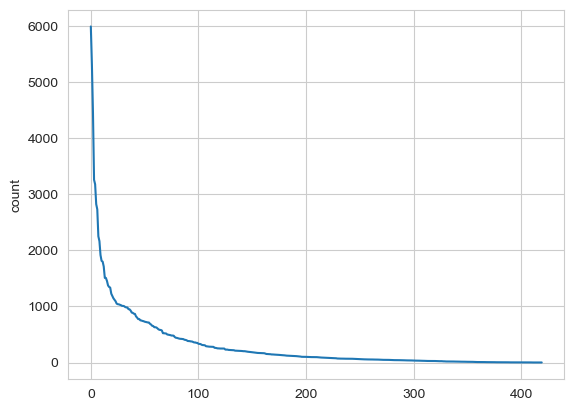

In [13]:
sns.lineplot(x = tag_counts.index, y = 'count', data = tag_counts);

In [14]:
tag_counts[0:50]

tag  count
0                adventure   5989
1             singleplayer   5313
2                   action   4452
3                       2d   3257
4                  fantasy   3177
5                   casual   2823
6                 strategy   2730
7                storyrich   2250
8            pixelgraphics   2163
9                actionrpg   1915
10              simulation   1812
11             exploration   1798
12                   anime   1711
13             atmospheric   1508
14               openworld   1508
15                    jrpg   1454
16                      3d   1374
17       femaleprotagonist   1347
18         turnbasedcombat   1336
19         actionadventure   1227
20                    cute   1184
21               roguelike   1145
22          dungeoncrawler   1118
23             multiplayer   1092
24                   magic   1050
25                 topdown   1040
26                colorful   1037
27                   retro   1030
28                rpgmaker   1022
29                survival   1010
30             thirdperson   1009
31           choicesmatter   1004
32                   funny    988
33               roguelite    983
34            hackandslash    981
35                  combat    951
36  charactercustomization    948
37               turnbased    926
38                  puzzle    890
39                medieval    885
40       turnbasedstrategy    870
41                   scifi    866
42        turnbasedtactics    822
43         multipleendings    801
44                  horror    775
45                crafting    775
46             firstperson    752
47             darkfantasy    749
48             visualnovel    741
49             strategyrpg    737

In [15]:
tag_counts[50:100]

tag  count
50               difficult    728
51         greatsoundtrack    723
52                 sandbox    717
53           partybasedrpg    714
54             tacticalrpg    713
55  chooseyourownadventure    690
56           sexualcontent    677
57                    coop    655
58                  nudity    650
59    proceduralgeneration    629
60                  comedy    629
61                 violent    624
62                 shooter    607
63         actionroguelike    590
64                tactical    582
65                     pve    580
66                    crpg    571
67               oldschool    523
68    massivelymultiplayer    522
69               textbased    519
70               isometric    517
71                    dark    500
72      interactivefiction    496
73              controller    491
74                    gore    488
75                     pvp    481
76                stylized    481
77              platformer    478
78                cartoony    454
79                relaxing    442
80                building    439
81                 mystery    432
82                  arcade    427
83          familyfriendly    423
84         postapocalyptic    422
85                     fps    419
86            2dplatformer    417
87              onlinecoop    406
88                    loot    403
89               handdrawn    397
90             replayvalue    384
91              management    383
92     psychologicalhorror    381
93                   space    376
94                   drama    375
95            sidescroller    367
96                      vr    358
97                cardgame    358
98                 zombies    351
99              permadeath    350

In [16]:
tag_counts[100:150]

tag  count
100               linear    334
101            realistic    332
102            soulslike    329
103              romance    316
104         basebuilding    311
105               mmorpg    310
106              cartoon    307
107             lorerich    291
108           bullethell    288
109               lgbtq+    287
110           futuristic    283
111           historical    282
112          point&click    281
113         3dplatformer    280
114               mature    279
115                memes    262
116              lifesim    261
117         immersivesim    257
118            datingsim    252
119            emotional    252
120                 2.5d    250
121   resourcemanagement    250
122       survivalhorror    250
123       topdownshooter    249
124            localcoop    249
125         conversation    231
126           minimalist    230
127         metroidvania    230
128          cardbattler    225
129            cyberpunk    224
130               demons    223
131         deckbuilding    223
132               1990's    222
133                  war    219
134               hentai    212
135               sports    211
136            boardgame    211
137              clicker    210
138  inventorymanagement    209
139              classic    207
140              dragons    206
141             tabletop    203
142   thirdpersonshooter    202
143    gridbasedmovement    202
144            darkhumor    198
145            swordplay    196
146       mysterydungeon    192
147           classbased    189
148              surreal    188
149                idler    186

In [17]:
tag_counts[150:200]

tag  count
150               beat'emup    183
151              shoot'emup    181
152                     rts    178
153                 stealth    177
154        localmultiplayer    171
155  openworldsurvivalcraft    171
156               narration    170
157            towerdefense    170
158        puzzleplatformer    169
159               nonlinear    168
160                  robots    167
161                  nature    166
162               detective    161
163               mythology    153
164        walkingsimulator    152
165                 physics    152
166              farmingsim    151
167                    nsfw    148
168            hiddenobject    144
169       creaturecollector    144
170            collectathon    142
171                  racing    141
172                 economy    140
173           investigation    140
174                  aliens    137
175         realtimetactics    136
176            lovecraftian    134
177               dystopian    133
178                fighting    131
179    traditionalroguelike    130
180        alternatehistory    128
181             citybuilder    125
182               education    123
183               comicbook    122
184          timemanagement    122
185     characteractiongame    119
186                military    118
187        twinstickshooter    118
188            supernatural    116
189               cinematic    116
190                   short    115
191             agriculture    114
192                   1980s    111
193                 wargame    110
194               2dfighter    108
195               teambased    106
196                moddable    102
197              darkcomedy    102
198                  gothic    102
199             autobattler    101

In [18]:
cutoff = 199
top_tags = set(tag_counts.loc[0:cutoff, 'tag'])

In [19]:
games['tags'] = games['tags'].apply(lambda x: list(set(x).intersection(top_tags)) if not set(x).isdisjoint(top_tags) else [])

In [20]:
games['num_reviews'].describe()

count    1.001600e+04
mean     1.731649e+03
std      2.450548e+04
min      0.000000e+00
25%      6.000000e+00
50%      2.900000e+01
75%      2.200000e+02
max      1.960357e+06
Name: num_reviews, dtype: float64

In [21]:
games = games[games['num_reviews'] > 20]

In [22]:
num_tags = games['tags'].apply(lambda x: len(x))
num_tags.describe()

count    5575.000000
mean       12.979013
std         5.304177
min         0.000000
25%         9.000000
50%        15.000000
75%        17.000000
max        19.000000
Name: tags, dtype: float64

In [29]:
games = games[num_tags > 5]

In [30]:
len(games)

4759

## PCA

In [31]:
tags_array = list(games['tags']) 
vectorizer = CountVectorizer(analyzer = lambda x : x)
X = vectorizer.fit_transform(tags_array).toarray()

In [32]:
X_0 = X - X.mean(axis = 0)

In [33]:
pca = PCA()
X_pca = pca.fit_transform(X_0)

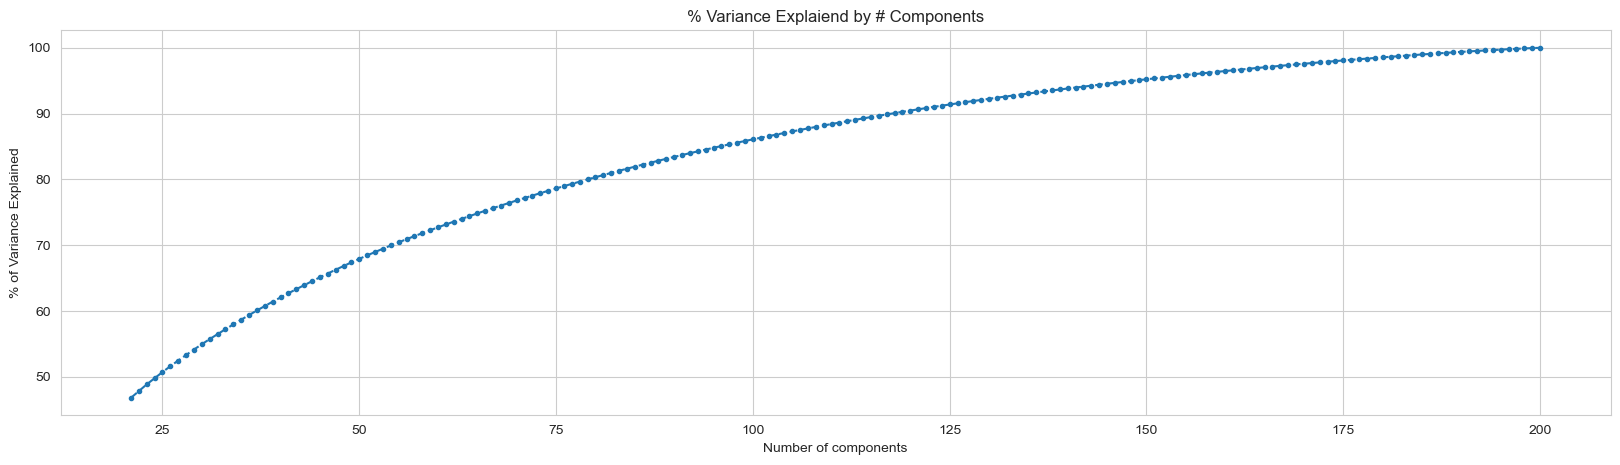

In [34]:
cumulative_variance_ratio = 100*np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (20,5))
plt.plot(range(21, 21 + len(cumulative_variance_ratio[20:])), cumulative_variance_ratio[20:], marker = '.', linestyle = '--')
plt.xlabel('Number of components')
plt.ylabel('% of Variance Explained')
plt.title('% Variance Explaiend by # Components')

plt.show()

In [35]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_0)

## KMeans

In [76]:
k_range = range(5, 36)

inertia = []
silhouette = []
models = []
for k in k_range:
    K_model = KMeans(n_clusters = k, max_iter = 200, init = 'k-means++', n_init = 10)
    K_model.fit(X_pca)
    inertia.append(K_model.inertia_)
    models.append(K_model)
    
    cluster_labels = K_model.fit_predict(X_pca)
    silhouette.append(silhouette_score(X_pca, cluster_labels))

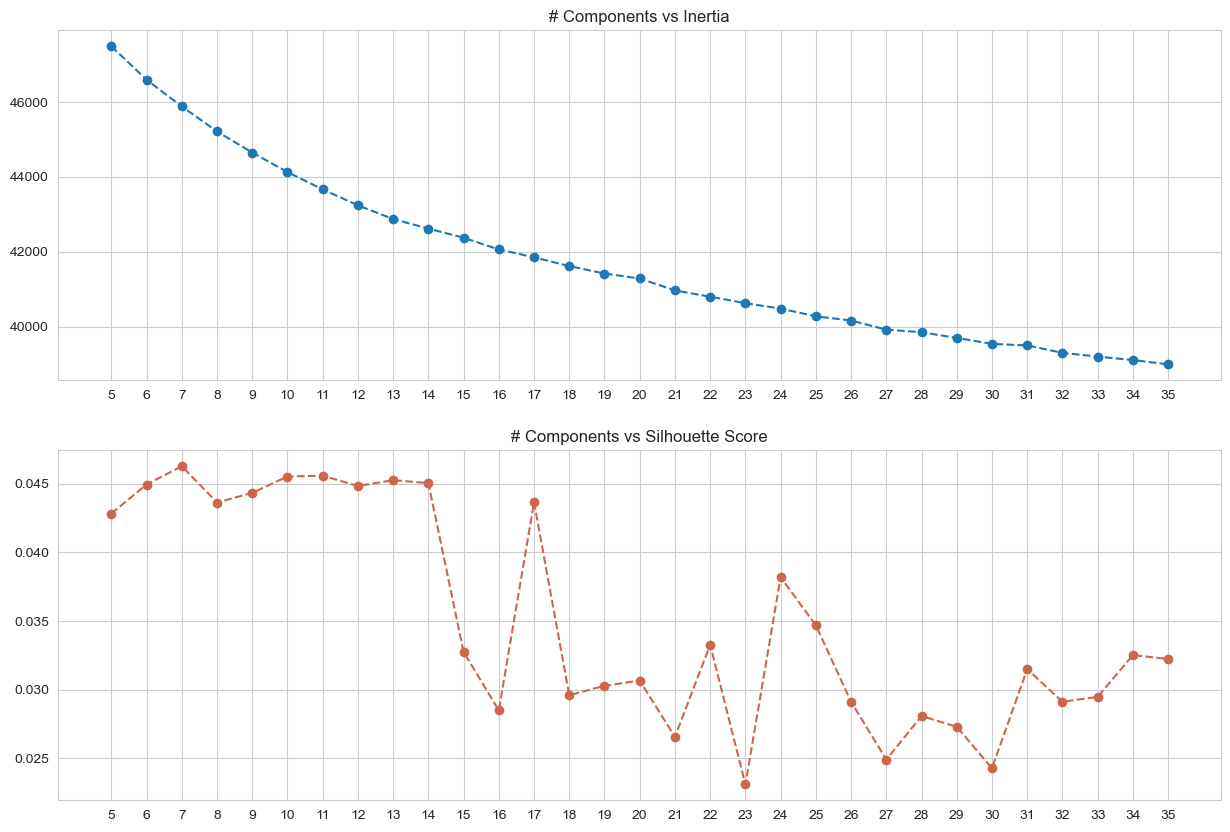

In [77]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))

axes[0].plot(k_range, inertia, marker = 'o', linestyle = '--')
axes[0].set_xticks(k_range)
axes[0].title.set_text('# Components vs Inertia')

axes[1].plot(k_range, silhouette, marker = 'o', linestyle = '--', color=[0.8, 0.4, 0.3])
axes[1].set_xticks(k_range)
axes[1].title.set_text('# Components vs Silhouette Score')

plt.show()

In [78]:
n_clusters = 17
model_n = models[k_range.index(n_clusters)]
clusters = model_n.fit_predict(X_pca);

In [79]:
games['cluster'] = clusters
games.reset_index(drop = True, inplace = True)
games[['name', 'tags', 'cluster']]

name  \
0                     Conquest Emperor   
1                           Idle Clans   
2                 EA SPORTS™ PGA TOUR™   
3                  Song Of The Prairie   
4                       Blocky Dungeon   
...                                ...   
4754           The Secret of Darkwoods   
4755  Disciples II: Rise of the Elves    
4756    Disciples II: Gallean's Return   
4757            The Ship: Murder Party   
4758         赌神模拟器：亚洲风云God Of Gamblers   

                                                   tags  cluster  
0     [sexualcontent, 2d, nudity, storyrich, adventu...        4  
1     [2d, cute, minimalist, fantasy, idler, singlep...        2  
2     [coop, localmultiplayer, sports, multiplayer, ...        7  
3     [cute, citybuilder, agriculture, storyrich, ro...        2  
4     [2d, traditionalroguelike, puzzle, gridbasedmo...        5  
...                                                 ...      ...  
4754  [nonlinear, choicesmatter, crpg, fantasy, sing...        3  
4755  [fantasy, turnbased, strategy, turnbasedstrate...       12  
4756  [isometric, fantasy, turnbased, strategy, turn...       12  
4757  [simulation, adventure, funny, comedy, singlep...       13  
4758  [sexualcontent, nudity, hentai, storyrich, sim...        4  

[4759 rows x 3 columns]

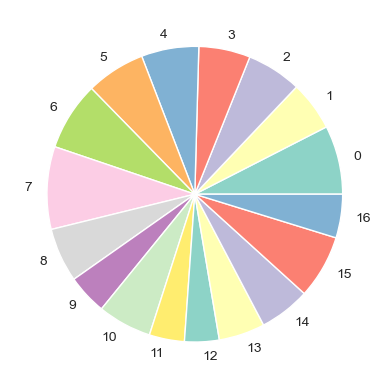

In [80]:
colors = sns.color_palette('Set3')[0:n_clusters]
plt.pie(games.groupby('cluster').size(), labels = range(0, n_clusters), colors = colors);

In [81]:
games[games['cluster'] == 7][['name', 'tags']].head(30)

name  \
2                                 EA SPORTS™ PGA TOUR™   
27                                           Ironheart   
36                           Sherlock Holmes - Nemesis   
40                                 Timeless Paradox VR   
47                          BEARS, VODKA, BALALAIKA! 🐻   
54                                      Broken Spell 2   
61                                     Pangea Survival   
75            Mage's Initiation: Reign of the Elements   
76                                          Dragonview   
77                             Uncharted Waters Online   
85                                        Lords Mobile   
126                                    Ninja Stealth 3   
127                     Defenders of Tetsoidea Academy   
140                    Realm Engine | Virtual Tabletop   
152                               You... and who else?   
154                                The Legend of Tango   
158                                    Assault Corps 2   
159                                           Apollo4x   
164                                          Deadstone   
179                                         Bot Colony   
182                                   Fearless Fantasy   
189                        Aveyond 3-2: Gates of Night   
207                                   Super Motherload   
214                                  7,62 High Calibre   
215  Hard Truck Apocalypse: Arcade / Ex Machina: Ar...   
221                                          NEStalgia   
228  Hard Truck Apocalypse: Rise Of Clans / Ex Mach...   
232                        FootLOL: Epic Soccer League   
251                   Call of Cthulhu: The Wasted Land   
281                                      Noir Syndrome   

                                                  tags  
2    [coop, localmultiplayer, sports, multiplayer, ...  
27   [adventure, singleplayer, action, casual, inte...  
36   [adventure, point&click, detective, investigat...  
40   [vr, adventure, action, anime, lorerich, femal...  
47   [military, thirdpersonshooter, simulation, fun...  
54   [sexualcontent, nudity, fighting, gore, simula...  
61   [gore, simulation, action, violent, openworld,...  
75   [magic, adventure, point&click, fantasy, pixel...  
76   [fighting, adventure, pixelgraphics, action, b...  
77   [adventure, strategy, anime, mmorpg, openworld...  
85   [gore, familyfriendly, strategy, war, massivel...  
126  [2d, collectathon, puzzle, adventure, strategy...  
127  [adventure, funny, fantasy, jrpg, rpgmaker, ac...  
140  [coop, citybuilder, simulation, adventure, iso...  
152  [strategyrpg, simulation, adventure, fantasy, ...  
154  [funny, adventure, comedy, singleplayer, rpgma...  
158  [simulation, adventure, strategy, sports, acti...  
159  [simulation, adventure, strategy, action, casu...  
164  [topdownshooter, zombies, strategy, action, sc...  
179  [simulation, textbased, adventure, funny, dete...  
182  [adventure, funny, comedy, fantasy, turnbased,...  
189  [adventure, jrpg, singleplayer, rpgmaker, casu...  
207  [localcoop, localmultiplayer, adventure, singl...  
214  [simulation, singleplayer, strategy, action, t...  
215  [adventure, singleplayer, action, racing, arca...  
221  [adventure, turnbased, jrpg, pixelgraphics, on...  
228  [adventure, atmospheric, multiplayer, action, ...  
232  [coop, simulation, funny, comedy, singleplayer...  
251  [lovecraftian, adventure, turnbased, strategy,...  
281  [adventure, detective, roguelike, pixelgraphic...

## Looking into each cluster

In [82]:
from math import dist, ceil

In [83]:
def find_nearest_points(center, points):
    nearest = points.pop()
    d_nearest = dist(center, nearest)
    for point in points:
        if dist(center, point) < d_nearest:
            nearest = point
            d_nearest = dist(center, nearest)

In [84]:
nearest_i = []

for n in range(n_clusters):
    all_i = np.where(model_n.labels_ == n)[0]
    points = X_pca[all_i]
    n_points = points.shape[0]
    
    center = model_n.cluster_centers_[n]
    
    distances = [dist(points[k], center) for k in range(n_points)]
    min_i = int(np.argmin(distances))
    min_i = all_i[min_i]
    nearest_i.append(int(min_i))

In [85]:
games.loc[nearest_i][['name', 'tags', 'cluster']]

name  \
4538  Gothic 3: Forsaken Gods Enhanced Edition   
872                                    Goliath   
810                                   The Farm   
1270                  VERSUS: The Elite Trials   
2262                        Chevalier Historie   
1520                     The Slimeking's Tower   
3232                              Unsung Story   
3946                          Clicker Warriors   
3481                              Fate Hunters   
1297                              Urban Empire   
2356                             FOX n FORESTS   
169                     FATE: The Traitor Soul   
261                         Eschalon: Book III   
4742                   The Ship: Single Player   
3524              The Forest of Drizzling Rain   
4428          The Alliance Alive HD Remastered   
156                     Dream Of Mirror Online   

                                                   tags  cluster  
4538  [adventure, thirdperson, fantasy, singleplayer...        0  
872   [sandbox, openworldsurvivalcraft, adventure, s...        1  
810   [2d, singleplayer, farmingsim, management, cas...        2  
1270  [storyrich, adventure, choicesmatter, chooseyo...        3  
2262  [sexualcontent, nudity, hentai, adventure, sin...        4  
1520  [adventure, actionroguelike, roguelike, roguel...        5  
3232  [strategyrpg, fantasy, strategy, turnbasedstra...        6  
3946  [simulation, adventure, strategy, clicker, act...        7  
3481  [adventure, roguelike, roguelite, strategy, tu...        8  
1297  [citybuilder, simulation, strategy, singleplay...        9  
2356  [2d, adventure, sidescroller, singleplayer, pi...       10  
169   [adventure, dungeoncrawler, fantasy, singlepla...       11  
261   [adventure, isometric, crpg, fantasy, turnbase...       12  
4742  [singleplayer, stealth, action, firstperson, f...       13  
3524  [2d, multipleendings, storyrich, adventure, si...       14  
4428  [adventure, fantasy, singleplayer, jrpg, turnb...       15  
156   [adventure, pvp, action, anime, mmorpg, massiv...       16

In [86]:
silhouette_coeff = silhouette_samples(X_pca, clusters)
games['silhouette_coeff'] = silhouette_coeff

In [87]:
games.loc[games.reset_index().groupby('cluster')['silhouette_coeff'].idxmax()][['name', 'tags', 'cluster']]

name  \
4127                   Hogwarts Legacy   
4743       Smalland: Survive the Wilds   
3092                     Idle Skilling   
1684  ARISEN - Chronicles of Var'Nagal   
1972  Obscurite Magie: The City of Sin   
1271                     Dungeon Souls   
2223                   Cascade Tactics   
2575                Ahlman Arcade 2018   
1024           Blood Card 2: Dark Mist   
1607                            SAELIG   
3001                              HAAK   
4594           Wolcen: Lords of Mayhem   
4511           Vampire's Fall: Origins   
4311                      Atomic Heart   
4533     Creepy Tale 3: Ingrid Penance   
2077                    EXCALIBURIAN!!   
2618                    Runes of Magic   

                                                   tags  cluster  
4127  [storyrich, exploration, atmospheric, openworl...        0  
4743  [sandbox, coop, citybuilder, openworldsurvival...        1  
3092  [2d, sandbox, cute, simulation, nonlinear, idl...        2  
1684  [2d, cute, storyrich, multipleendings, romance...        3  
1972  [sexualcontent, nudity, hentai, adventure, sin...        4  
1271  [2d, localcoop, bullethell, adventure, actionr...        5  
2223  [2d, magic, strategyrpg, 2.5d, isometric, fant...        6  
2575  [gore, simulation, adventure, sports, action, ...        7  
1024  [2d, difficult, fantasy, turnbased, singleplay...        8  
1607  [sandbox, openworld, strategyrpg, lifesim, sim...        9  
3001  [metroidvania, 2d, adventure, sidescroller, po...       10  
4594  [coop, adventure, isometric, dungeoncrawler, f...       11  
4511  [storyrich, adventure, crpg, isometric, fantas...       12  
4311  [exploration, robots, fps, openworld, alternat...       13  
4533  [2d, storyrich, sidescroller, adventure, point...       14  
2077  [2d, cute, magic, nonlinear, adventure, fantas...       15  
2618  [magic, openworld, mysterydungeon, adventure, ...       16

In [95]:
rep_games = games[games['silhouette_coeff'] > 0].sort_values('num_positive_reviews').drop_duplicates(['cluster'], keep='last')
rep_games = rep_games[['name', 'tags', 'cluster']].sort_values('cluster')
rep_games

name  \
474                      The Witcher® 3: Wild Hunt   
1752                         ARK: Survival Evolved   
797                                 Stardew Valley   
2151                           Mirror 2: Project X   
3533                               Action Taimanin   
3606                                         Hades   
748                                        XCOM® 2   
1942                                    Battlerite   
2969                                Slay the Spire   
4442                             Crusader Kings II   
883   Ori and the Blind Forest: Definitive Edition   
4246                                      Warframe   
899                           Total War: WARHAMMER   
4504                                    Fallout 76   
564                                      Undertale   
3216                                         OMORI   
1705                                     New World   

                                                   tags  cluster  
474   [storyrich, atmospheric, openworld, choicesmat...        0  
1752  [sandbox, coop, openworldsurvivalcraft, advent...        1  
797   [2d, sandbox, cute, agriculture, lifesim, simu...        2  
2151  [storyrich, multipleendings, adventure, single...        3  
3533  [sexualcontent, nudity, hentai, fighting, adve...        4  
3606  [storyrich, isometric, actionroguelike, dungeo...        5  
748   [permadeath, difficult, atmospheric, openworld...        6  
1942  [topdownshooter, fighting, difficult, strategy...        7  
2969  [2d, difficult, dungeoncrawler, turnbased, sin...        8  
4442  [sandbox, moddable, simulation, singleplayer, ...        9  
883   [metroidvania, 2d, cute, storyrich, openworld,...       10  
4246  [coop, thirdpersonshooter, thirdperson, single...       11  
899   [coop, storyrich, gore, fantasy, turnbased, wa...       12  
4504  [coop, openworld, darkcomedy, gore, mmorpg, si...       13  
564   [2d, cute, bullethell, storyrich, multipleendi...       14  
3216  [2d, storyrich, multipleendings, fantasy, turn...       15  
1705  [crafting, openworld, pvp, massivelymultiplaye...       16

In [96]:
reps = rep_games['name'].tolist()
reps

['The Witcher® 3: Wild Hunt',
 'ARK: Survival Evolved',
 'Stardew Valley',
 'Mirror 2: Project X',
 'Action Taimanin',
 'Hades',
 'XCOM® 2',
 'Battlerite',
 'Slay the Spire',
 'Crusader Kings II',
 'Ori and the Blind Forest: Definitive Edition',
 'Warframe',
 'Total War: WARHAMMER',
 'Fallout 76',
 'Undertale',
 'OMORI',
 'New World']

In [113]:
games[games['cluster'] == 13].sort_values(by = 'silhouette_coeff', ascending = False)[['name', 'tags', 'silhouette_coeff','num_reviews']].head(50)

name  \
4311                                       Atomic Heart   
4626  The Walking Dead: Saints & Sinners - Chapter 2...   
1577                      Beyond Mankind: The Awakening   
909                                       Dead Effect 2   
2471                                         Affliction   
2775                              Wandering in space VR   
4451                           E.Y.E: Divine Cybermancy   
2602                                Maroon Berets: 2030   
2846                                   HELLGATE: London   
1282                       Guardians of Orion (Phase 2)   
778                                             NeonXSZ   
4162                               Interstellar Marines   
1623                                      Agent Roswell   
4025                                      P.A.M.E.L.A.®   
655                                 Andromeda 2 Zombies   
1487                                               Prey   
367                             Strife: Veteran Edition   
1871                              SAS: Zombie Assault 4   
273                                           Black Ice   
2703                          Alien Shooter 2 - New Era   
3911                              Andromeda One Zombies   
3998                                     Earth's Shadow   
4709                          S.T.A.L.K.E.R.: Clear Sky   
4615                    S.T.A.L.K.E.R.: Call of Pripyat   
4400                       Alien Shooter 2 - The Legend   
634                      System Shock: Enhanced Edition   
2067                                           Bitardia   
2079                      The Walking Zombie: Dead City   
2003                                      Wrought Flesh   
1870                                   Dead Effect 2 VR   
888                               CYBER EMOJI TALE 2099   
131                                              GRAVEN   
4576                                      Alien Shooter   
1891                          8089: The Next Action RPG   
336                                            TRON 2.0   
4421                 The Walking Dead: Saints & Sinners   
2292                  Buccaneers! The New Age of Piracy   
1263                               Xenus 2. White gold.   
4075                      3089 -- Futuristic Action RPG   
4269                                         Family Man   
4313                               Family Man: Prologue   
56                                          Project RIP   
1648                           Solstice Chronicles: MIA   
1641                                          Bloodwash   
4625             STAR WARS™ Jedi Knight - Jedi Academy™   
780                                5089: The Action RPG   
743                                         Disjunction   
1321                              Airtight City 密闭之城1.0   
2672                             Dying Light: Bad Blood   
2889                                        Dissolution   

                                                   tags  silhouette_coeff  \
4311  [exploration, robots, fps, openworld, alternat...          0.064391   
4626  [fps, openworld, vr, gore, choicesmatter, comb...          0.053468   
1577  [military, storyrich, choicesmatter, adventure...          0.052859   
909   [coop, zombies, openworld, gore, pvp, singlepl...          0.051656   
2471  [storyrich, linear, comicbook, stylized, psych...          0.045016   
2775  [vr, zombies, gore, survival, adventure, actio...          0.041648   
4451  [coop, immersivesim, storyrich, adventure, sur...          0.039742   
2602  [openworld, gore, thirdpersonshooter, thirdper...          0.039285   
2846  [zombies, gore, thirdpersonshooter, thirdperso...          0.038425   
1282  [topdownshooter, coop, openworld, gore, thirdp...          0.037819   
778   [sandbox, openworld, funny, difficult, rogueli...          0.037067   
4162  [coop, simulation, singleplayer, space, atmosp...          0.036431   
1623  [sandbox, bullethell, thirdpersons

In [114]:
reps = ['The Witcher 3, Hogwarts Legacy',
 'ARK: Survival Evolved, Valheim',
 'Stardew Valley',
 'The Life and Suffering of Sir Brante',
 'Action Taimanin',
 'The Binding of Isaac, Hades',
 'XCOM 2',
 'Battlerite',
 'Slay the Spire',
 'Crusader Kings II',
 'Ori and the Blind Forest, Castlevania',
 'Wolcen: Lords of Mayhem, Grim Dawn',
 'Divinity: Original Sin, Pillars of Eternity',
 'Prey, S.T.A.L.K.E.R. series',
 'Undertale',
 'FINAL FANTASY',
 'New World, The Elder Scrolls Online']

In [115]:
features = vectorizer.get_feature_names_out()

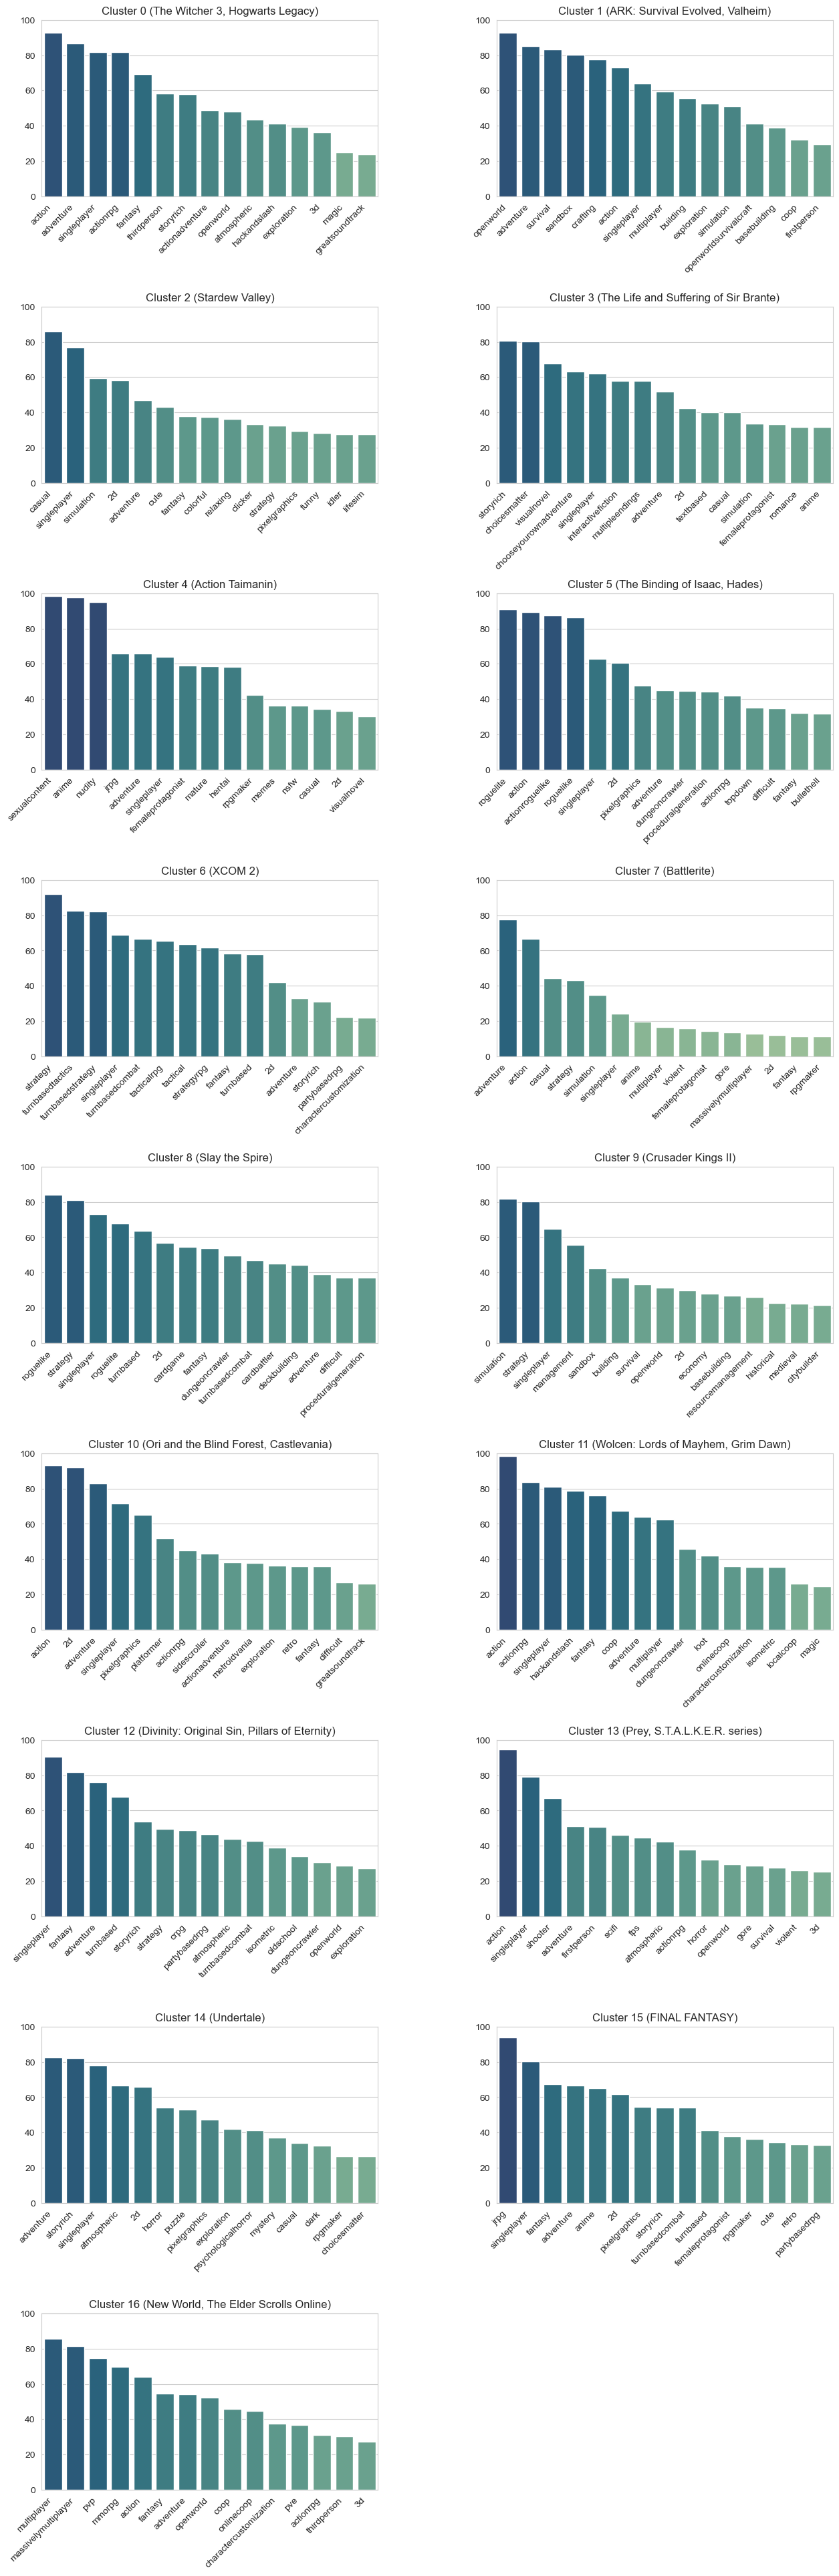

In [117]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 40))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    i_n = X[np.where(clusters == n)]
    N = len(X[i_n])
    
    tag_percentages = sum(i_n, 1) * 100 / N
    
    i_common = np.argsort(-tag_percentages)[0:15]
    common_tags_per = tag_percentages[i_common]
    common_tags = features[i_common]
    
    plot_df = pd.DataFrame({'x': common_tags, 'y': common_tags_per})
    plot_df['hue'] = plot_df.apply(lambda row: (row['y'] > 66 and 2) or (row['y'] > 33 and 1) or 0, axis = 1)
    
    palette = sns.color_palette("crest", 15)
    color_i = np.floor(common_tags_per*15/100).astype(np.int32) - 1
    sns.barplot(ax = axes[n//2, n%2], x = common_tags, y = common_tags_per, 
                palette = np.array(palette).take(color_i, axis = 0))
    
    axes[n//2, n%2].set_xticklabels(common_tags[0:15], rotation = 45, ha = 'right')
    axes[n//2, n%2].set_ylim(0, 100)
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')

    
plt.show()

## Trend Analysis

In [118]:
import datetime

In [121]:
games['release_date'] = games['release_year']*10000 + games['release_month']*100 + games['release_day']
games['release_date'] = pd.to_datetime(games['release_date'], format='%Y%m%d')
games['release_q'] = games['release_date'].dt.to_period('Q')

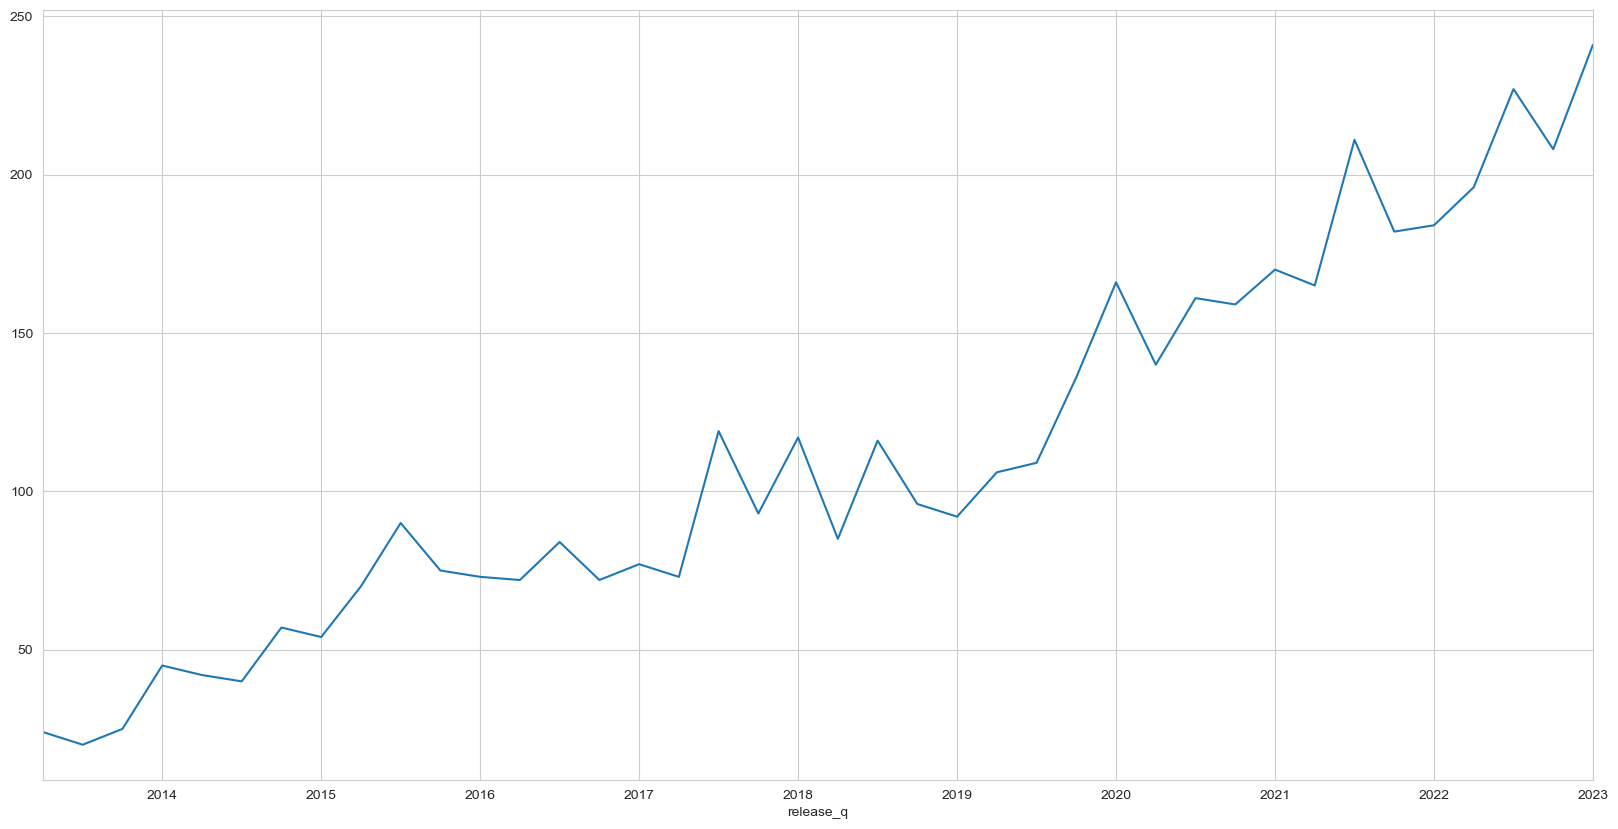

In [122]:
plot_df = games[('2013-04-01' <= games['release_date']) & (games['release_date'] < '2023-04-01')].groupby(['release_q','cluster']).agg(count=('cluster', 'count'))
plot_df = plot_df.unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df[['release_q', 'count']].groupby('release_q').sum().plot(legend = False, figsize = (20, 10));

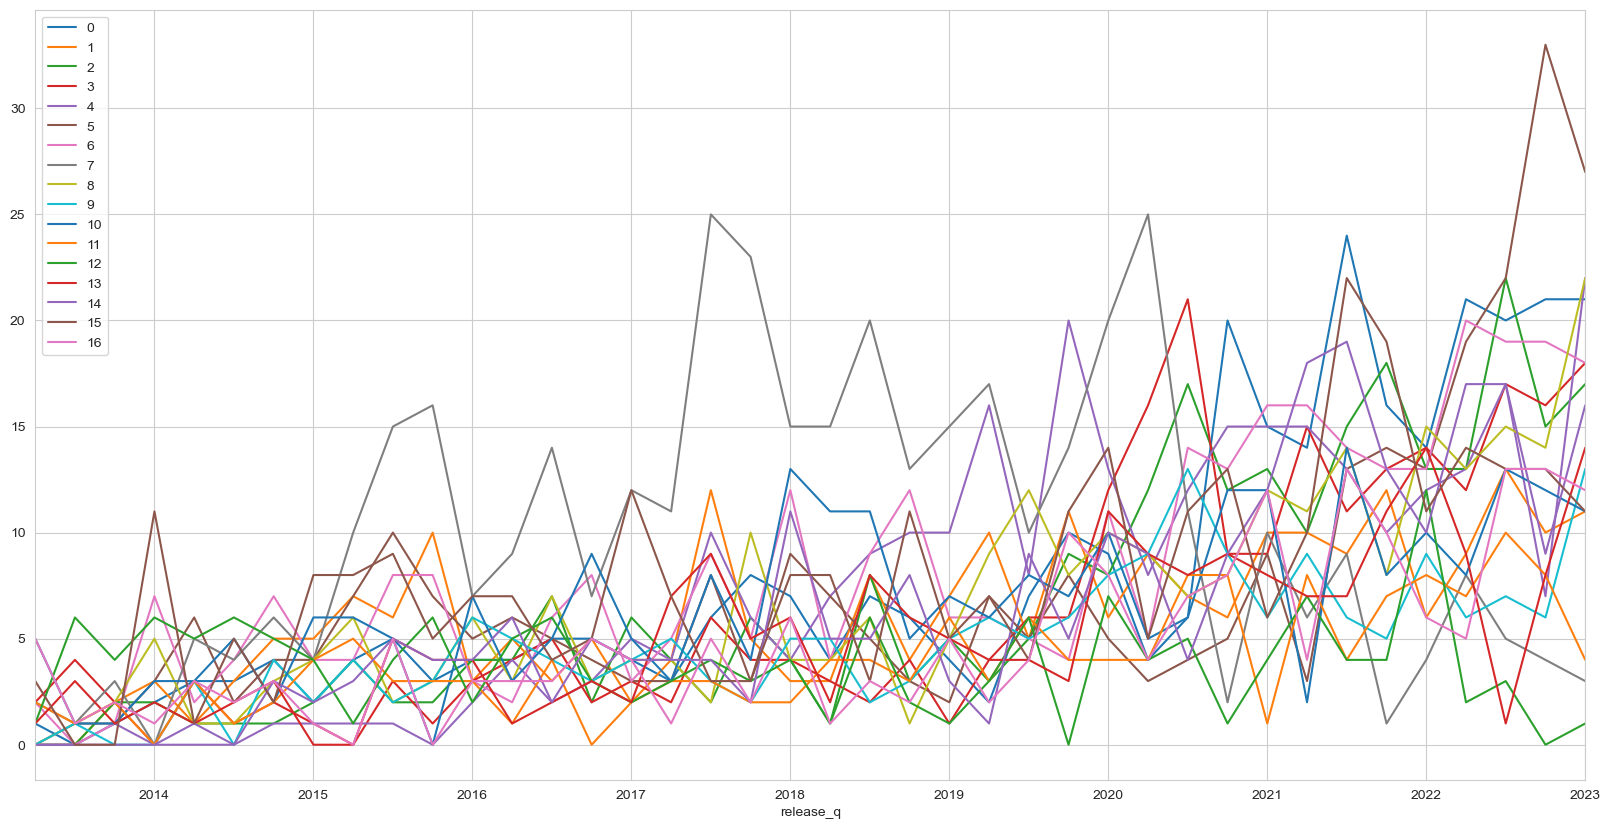

In [123]:
plot_df.set_index('release_q').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [124]:
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset

In [125]:
# Convert Quarters to actual dates (end date of each quarter) for plotting.
plot_df['release_q'] = plot_df['release_q'].dt.to_timestamp() 

In [126]:
quarters = (pd.date_range(pd.to_datetime('2013-04-01'), pd.to_datetime('2023-03-31') + pd.offsets.QuarterBegin(1), freq='Q').to_period('Q').
            strftime('%Y Q%q').tolist())

for i in range(len(quarters)):
    if 'Q1' in quarters[i]:
        quarters[i] = quarters[i].split(' ')[0]
    else:
        quarters[i] = ''

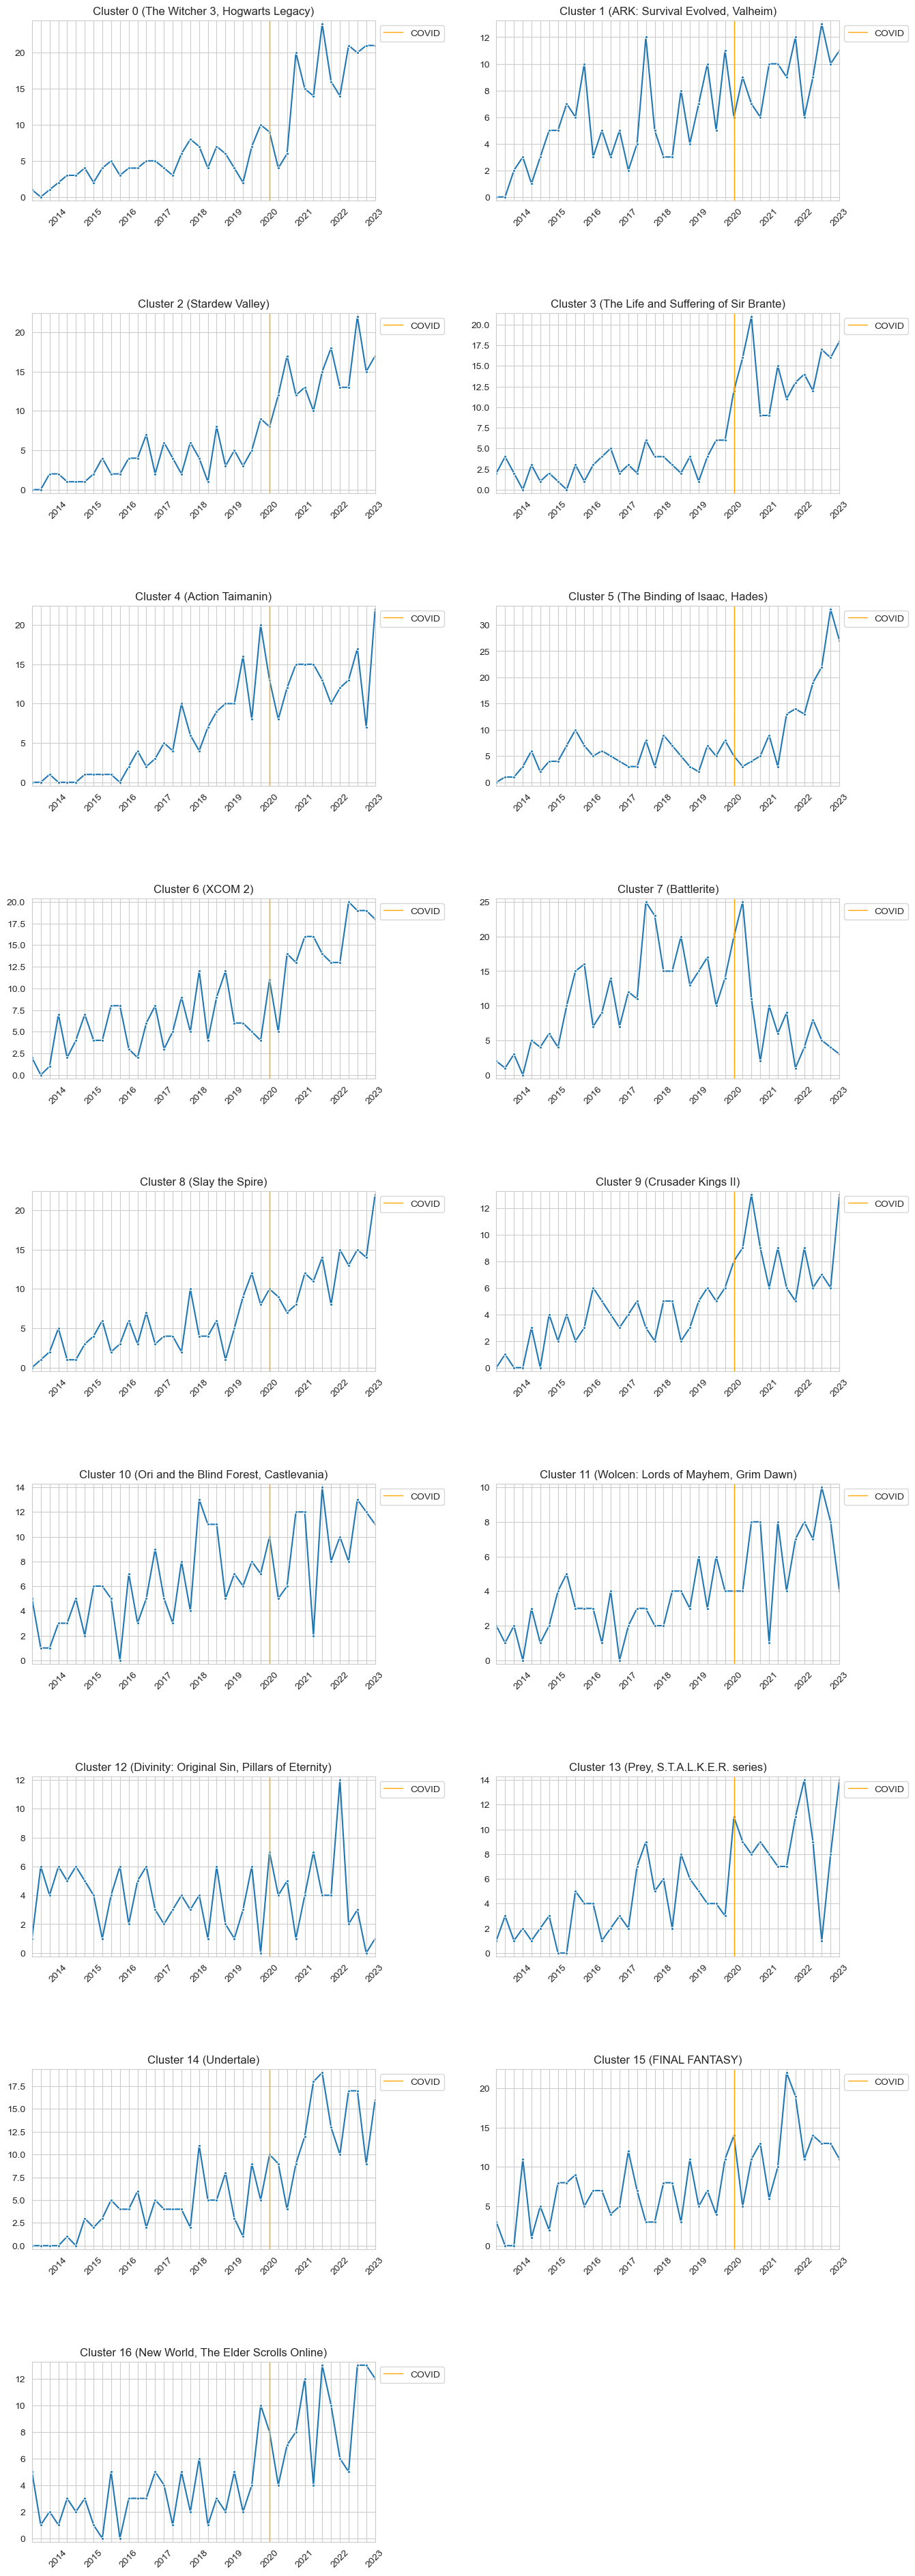

In [128]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 40))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_q', y = 'count', ax = axes[n//2, n%2], marker = '.');
    
    axes[n//2, n%2].axvline(x = pd.Timestamp(2020,1,1), lw = 1, ls = '-', color = 'orange', label = 'COVID')
    
    axes[n//2, n%2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[n//2, n%2].set_xticklabels(quarters, rotation = 45, ha = 'center')
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.02)
       
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')


if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()

In [129]:
plot_df = games.groupby(['release_year','cluster']).agg(count=('cluster', 'count')).unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df = plot_df[(2003 <= plot_df['release_year']) & (plot_df['release_year'] < 2023)]

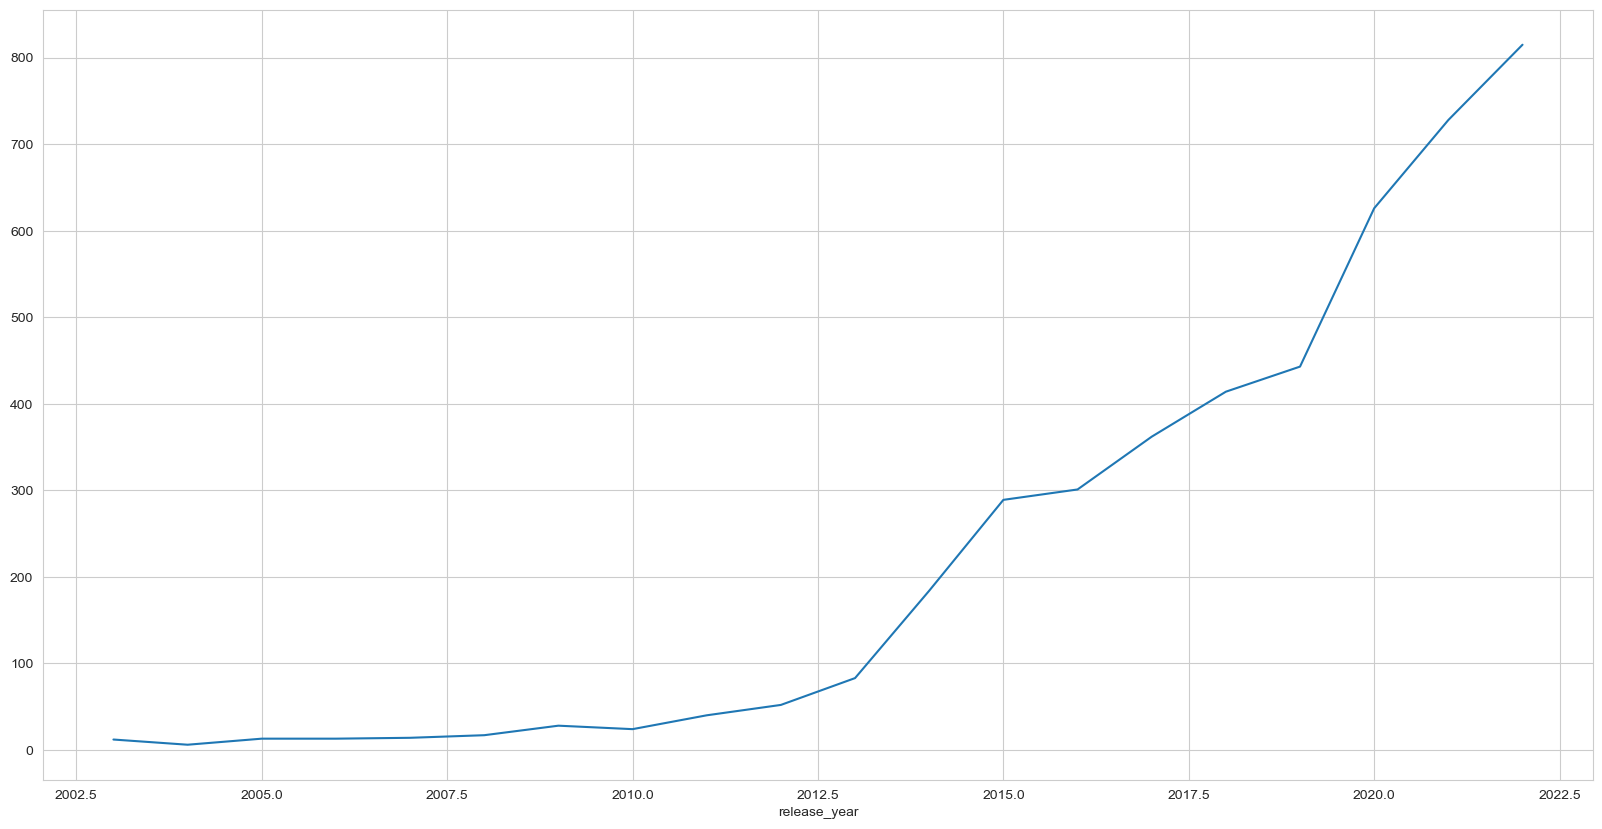

In [130]:
d = plot_df[['release_year', 'count']].groupby('release_year').sum().plot(figsize = (20, 10), legend = False);

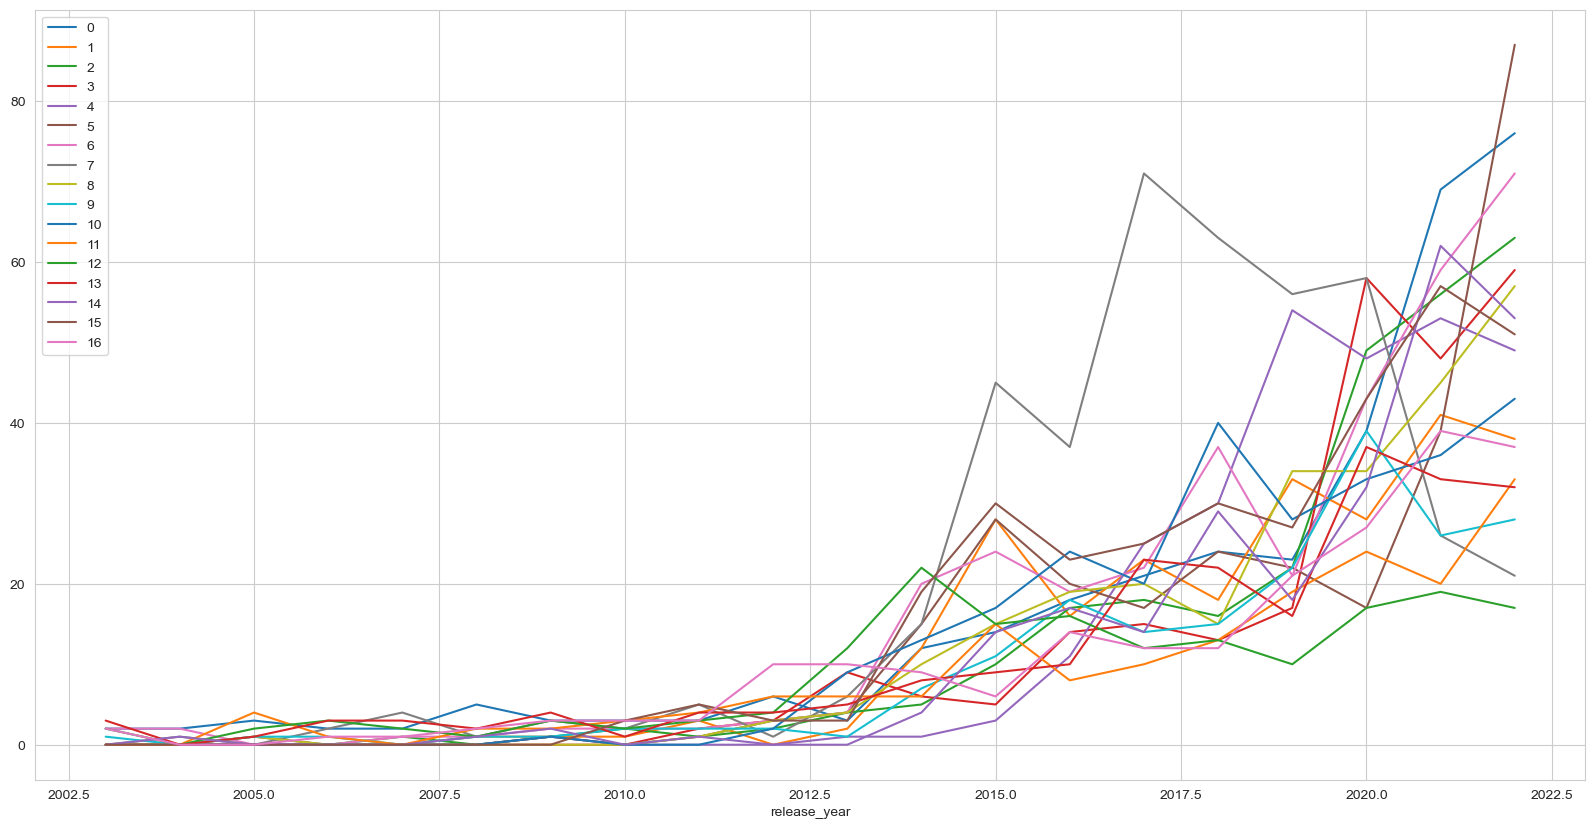

In [131]:
plot_df.set_index('release_year').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [132]:
from matplotlib.ticker import MaxNLocator

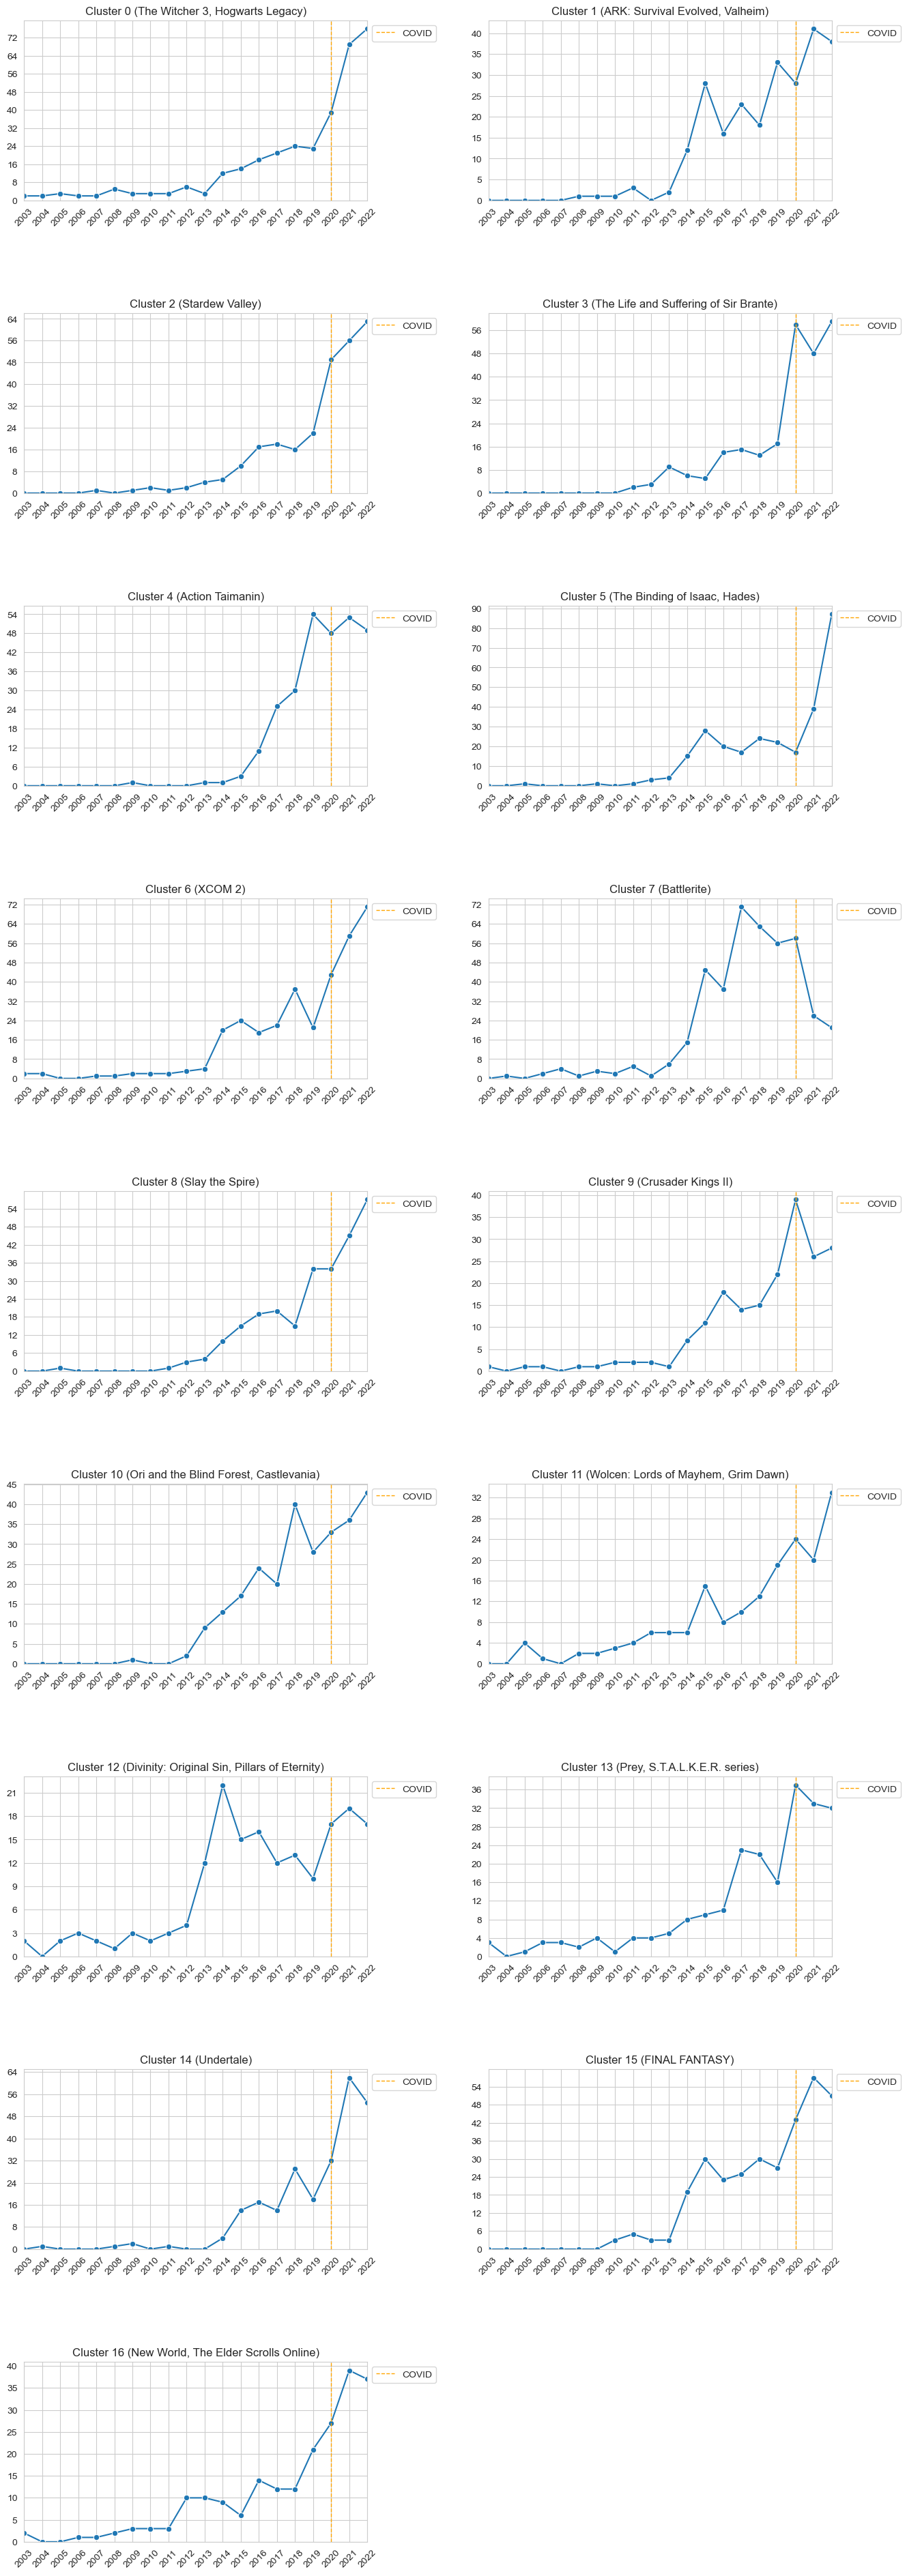

In [133]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 40))
fig.tight_layout(pad = 10.0)

years = [y for y in range(2003, 2023)]

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_year', y = 'count', ax = axes[n//2, n%2], marker = 'o');
    
    axes[n//2, n%2].axvline(x = 2020, lw = 1, ls = '--', color = 'orange', label = 'COVID')

    axes[n//2, n%2].set_xticks(years)
    axes[n//2, n%2].set_xticklabels(years, rotation = 45, ha = 'center')
    
    axes[n//2, n%2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[n//2, n%2].set_ylim(ymin=0)
    
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.2)
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()

## Repeating with 14 clusters

In [134]:
n_clusters = 14
model_n = models[k_range.index(n_clusters)]
clusters = model_n.fit_predict(X_pca);

In [135]:
games['cluster'] = clusters
games.reset_index(drop = True, inplace = True)
games[['name', 'tags', 'cluster']]

name  \
0                     Conquest Emperor   
1                           Idle Clans   
2                 EA SPORTS™ PGA TOUR™   
3                  Song Of The Prairie   
4                       Blocky Dungeon   
...                                ...   
4754           The Secret of Darkwoods   
4755  Disciples II: Rise of the Elves    
4756    Disciples II: Gallean's Return   
4757            The Ship: Murder Party   
4758         赌神模拟器：亚洲风云God Of Gamblers   

                                                   tags  cluster  
0     [sexualcontent, 2d, nudity, storyrich, adventu...        6  
1     [2d, cute, minimalist, fantasy, idler, singlep...       12  
2     [coop, localmultiplayer, sports, multiplayer, ...        0  
3     [cute, citybuilder, agriculture, storyrich, ro...       12  
4     [2d, traditionalroguelike, puzzle, gridbasedmo...        8  
...                                                 ...      ...  
4754  [nonlinear, choicesmatter, crpg, fantasy, sing...        3  
4755  [fantasy, turnbased, strategy, turnbasedstrate...        1  
4756  [isometric, fantasy, turnbased, strategy, turn...        1  
4757  [simulation, adventure, funny, comedy, singlep...       10  
4758  [sexualcontent, nudity, hentai, storyrich, sim...        6  

[4759 rows x 3 columns]

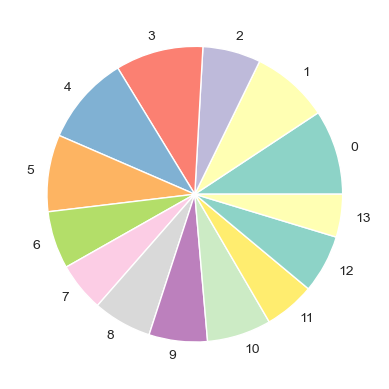

In [136]:
colors = sns.color_palette('Set3')[0:n_clusters]
plt.pie(games.groupby('cluster').size(), labels = range(0, n_clusters), colors = colors);

In [137]:
games[games['cluster'] == 7][['name', 'tags']].head(30)

name  \
41                           Mabinogi   
49                       Anomaly Zone   
88                          Spellwake   
105                    Arena of Kings   
113                          The Wolf   
118                              MIR4   
125              Isekai Eternal Alpha   
156            Dream Of Mirror Online   
206                       ArcheBlade™   
218           GunZ 2: The Second Duel   
235                      Original War   
242          FINAL FANTASY XIV Online   
266                  Fiesta Online NA   
267                           Elsword   
299              Villagers and Heroes   
317                             WAKFU   
352                         Perpetuum   
362                         The Crew™   
365                 School of Dragons   
378                  The Repopulation   
419                           8BitMMO   
449               RUNNING WITH RIFLES   
478                         Magicka 2   
516                           Aberoth   
574                            SMITE®   
581                       Astro Lords   
643  Sphere 3: Rage of the Devastator   
645                           GranAge   
676                           Mytheon   
685                    Lost Existence   

                                                  tags  
41   [cute, sandbox, openworld, storyrich, lifesim,...  
49   [zombies, survival, multiplayer, action, onlin...  
88   [magic, pvp, isometric, fantasy, 3d, action, c...  
105  [topdownshooter, pvp, isometric, pve, action, ...  
113  [coop, immersivesim, combat, thirdperson, part...  
118  [magic, thirdperson, demons, fantasy, war, mas...  
125  [magic, coop, pvp, fantasy, strategy, 3d, acti...  
156  [adventure, pvp, action, anime, mmorpg, massiv...  
206  [coop, fighting, thirdpersonshooter, adventure...  
218  [coop, fighting, thirdpersonshooter, adventure...  
235  [2d, coop, storyrich, moddable, wargame, war, ...  
242  [storyrich, onlinecoop, femaleprotagonist, atm...  
266  [nudity, adventure, fantasy, action, anime, mm...  
267  [2d, coop, cute, fighting, adventure, sidescro...  
299  [magic, coop, sandbox, openworld, funny, adven...  
317  [2d, coop, sandbox, adventure, isometric, fant...  
352  [sandbox, pvp, action, robots, scifi, mmorpg, ...  
362  [sandbox, coop, simulation, singleplayer, atmo...  
365  [coop, openworld, simulation, familyfriendly, ...  
378  [sandbox, openworldsurvivalcraft, survival, pv...  
419  [2d, coop, sandbox, funny, adventure, pvp, bui...  
449  [topdownshooter, military, sandbox, coop, modd...  
478  [localmultiplayer, funny, onlinecoop, atmosphe...  
516  [2d, coop, sandbox, medieval, adventure, fanta...  
574  [coop, mythology, funny, pvp, thirdperson, adv...  
581  [sandbox, simulation, pvp, strategy, space, pv...  
643  [openworld, adventure, crpg, thirdperson, fant...  
645  [2d, cute, storyrich, fantasy, dungeoncrawler,...  
676  [adventure, pvp, pve, action, classic, mmorpg,...  
685  [magic, coop, sandbox, moddable, adventure, fa...

## Looking into each cluster

In [138]:
from math import dist, ceil

In [139]:
def find_nearest_points(center, points):
    nearest = points.pop()
    d_nearest = dist(center, nearest)
    for point in points:
        if dist(center, point) < d_nearest:
            nearest = point
            d_nearest = dist(center, nearest)

In [140]:
nearest_i = []

for n in range(n_clusters):
    all_i = np.where(model_n.labels_ == n)[0]
    points = X_pca[all_i]
    n_points = points.shape[0]
    
    center = model_n.cluster_centers_[n]
    
    distances = [dist(points[k], center) for k in range(n_points)]
    min_i = int(np.argmin(distances))
    min_i = all_i[min_i]
    nearest_i.append(int(min_i))

In [141]:
games.loc[nearest_i][['name', 'tags', 'cluster']]

name  \
3946                          Clicker Warriors   
3232                              Unsung Story   
3481                              Fate Hunters   
168                                     Unrest   
4538  Gothic 3: Forsaken Gods Enhanced Edition   
4428          The Alliance Alive HD Remastered   
2262                        Chevalier Historie   
156                     Dream Of Mirror Online   
1520                     The Slimeking's Tower   
2356                             FOX n FORESTS   
1346                     Diluvion: Resubmerged   
872                                    Goliath   
810                                   The Farm   
1297                              Urban Empire   

                                                   tags  cluster  
3946  [simulation, adventure, strategy, clicker, act...        0  
3232  [strategyrpg, fantasy, strategy, turnbasedstra...        1  
3481  [adventure, roguelike, roguelite, strategy, tu...        2  
168   [storyrich, choicesmatter, adventure, fantasy,...        3  
4538  [adventure, thirdperson, fantasy, singleplayer...        4  
4428  [adventure, fantasy, singleplayer, jrpg, turnb...        5  
2262  [sexualcontent, nudity, hentai, adventure, sin...        6  
156   [adventure, pvp, action, anime, mmorpg, massiv...        7  
1520  [adventure, actionroguelike, roguelike, roguel...        8  
2356  [2d, adventure, sidescroller, singleplayer, pi...        9  
1346  [openworld, adventure, singleplayer, action, g...       10  
872   [sandbox, openworldsurvivalcraft, adventure, s...       11  
810   [2d, singleplayer, farmingsim, management, cas...       12  
1297  [citybuilder, simulation, strategy, singleplay...       13

In [142]:
silhouette_coeff = silhouette_samples(X_pca, clusters)
games['silhouette_coeff'] = silhouette_coeff

In [143]:
games.loc[games.reset_index().groupby('cluster')['silhouette_coeff'].idxmax()][['name', 'tags', 'cluster']]

name  \
2575                 Ahlman Arcade 2018   
2560                        Age of Grit   
1024            Blood Card 2: Dark Mist   
4353  Saint Maker - Horror Visual Novel   
262                      Bound By Flame   
3562           The Dragons' Twilight II   
1972   Obscurite Magie: The City of Sin   
2618                     Runes of Magic   
2840                        Tor Eternum   
3001                               HAAK   
4311                       Atomic Heart   
4743        Smalland: Survive the Wilds   
753                            Plantera   
1115      Siege Survival: Gloria Victis   

                                                   tags  cluster  
2575  [gore, simulation, adventure, sports, action, ...        0  
2560  [2d, storyrich, strategyrpg, crpg, fantasy, tu...        1  
1024  [2d, difficult, fantasy, turnbased, singleplay...        2  
4353  [2d, storyrich, multipleendings, choicesmatter...        3  
262   [storyrich, demons, difficult, femaleprotagoni...        4  
3562  [2d, magic, storyrich, adventure, fantasy, tur...        5  
1972  [sexualcontent, nudity, hentai, adventure, sin...        6  
2618  [magic, openworld, mysterydungeon, adventure, ...        7  
2840  [2d, coop, actionroguelike, fantasy, dungeoncr...        8  
3001  [metroidvania, 2d, adventure, sidescroller, po...        9  
4311  [exploration, robots, fps, openworld, alternat...       10  
4743  [sandbox, coop, citybuilder, openworldsurvival...       11  
753   [2d, cute, sandbox, agriculture, collectathon,...       12  
1115  [strategyrpg, timemanagement, crafting, econom...       13

In [144]:
rep_games = games[games['silhouette_coeff'] > 0].sort_values('num_positive_reviews').drop_duplicates(['cluster'], keep='last')
rep_games = rep_games[['name', 'tags', 'cluster']].sort_values('cluster')
rep_games

name  \
1942                                     Battlerite   
1800  Divinity: Original Sin 2 - Definitive Edition   
2969                                 Slay the Spire   
564                                       Undertale   
474                       The Witcher® 3: Wild Hunt   
3216                                          OMORI   
3533                                Action Taimanin   
1705                                      New World   
3606                                          Hades   
883    Ori and the Blind Forest: Definitive Edition   
1487                                           Prey   
1752                          ARK: Survival Evolved   
797                                  Stardew Valley   
3766                             Crusader Kings III   

                                                   tags  cluster  
1942  [topdownshooter, fighting, difficult, strategy...        0  
1800  [storyrich, strategyrpg, romance, moddable, fu...        1  
2969  [2d, difficult, dungeoncrawler, turnbased, sin...        2  
564   [2d, cute, bullethell, storyrich, multipleendi...        3  
474   [storyrich, atmospheric, openworld, choicesmat...        4  
3216  [2d, storyrich, multipleendings, fantasy, turn...        5  
3533  [sexualcontent, nudity, hentai, fighting, adve...        6  
1705  [crafting, openworld, pvp, massivelymultiplaye...        7  
3606  [storyrich, isometric, actionroguelike, dungeo...        8  
883   [metroidvania, 2d, cute, storyrich, openworld,...        9  
1487  [storyrich, exploration, fps, atmospheric, ope...       10  
1752  [sandbox, coop, openworldsurvivalcraft, advent...       11  
797   [2d, sandbox, cute, agriculture, lifesim, simu...       12  
3766  [sandbox, moddable, simulation, lifesim, choic...       13

In [145]:
reps = rep_games['name'].tolist()
reps

['Battlerite',
 'Divinity: Original Sin 2 - Definitive Edition',
 'Slay the Spire',
 'Undertale',
 'The Witcher® 3: Wild Hunt',
 'OMORI',
 'Action Taimanin',
 'New World',
 'Hades',
 'Ori and the Blind Forest: Definitive Edition',
 'Prey',
 'ARK: Survival Evolved',
 'Stardew Valley',
 'Crusader Kings III']

In [176]:
games[games['cluster'] == 13].sort_values(by = 'silhouette_coeff', ascending = False)[['name', 'tags', 'silhouette_coeff','num_reviews']].head(50)

name  \
1115           Siege Survival: Gloria Victis   
1607                                  SAELIG   
2048                           Kubifaktorium   
2759                              Anvil Saga   
1852                        Empire Architect   
4555                The Guild II Renaissance   
4517                          Meeple Station   
3795  Siege Survival: Gloria Victis Prologue   
1931                              Hammerting   
2886  Desktopia: A Desktop Village Simulator   
4554                            The Guild II   
1021                        Conqueror 940 AD   
1130                            SimPocalypse   
1369             Dream Engines: Nomad Cities   
2313               The Spatials: Galactology   
1688                             Sheltered 2   
3766                      Crusader Kings III   
2878                           Cartel Tycoon   
3891                      Rogue AI Simulator   
3318           Amazing Cultivation Simulator   
3655                          Dwarf Fortress   
1396                    The Vagabond Emperor   
3601                           Live the Life   
485           Rebuild 3: Gangs of Deadsville   
3692       Potion Craft: Alchemist Simulator   
3189            Driftland: The Magic Revival   
4308                      Empires and Tribes   
1219                          Going Medieval   
4523                           Big Ambitions   
2768                               Feartress   
2359               最后的巫后：众王纷争的年代 Witch Queen   
3396                 Raiders! Forsaken Earth   
3410                       Against the Storm   
626           A Little Shop in Squirrel Town   
2675                        Game Dev Masters   
4441                Final Profit: A Shop RPG   
1983                      Music Band Manager   
2220                       Pure Farming 2018   
3805                           Rising Star 2   
4721                              Dwarf Shop   
628                         Kingdom: Classic   
2310                         This Grand Life   
3754       Gladiator Guild Manager: Prologue   
259                            Kingdom Tales   
2695                             The Guild 3   
3780             Warsim: The Realm of Aslona   
4288                                   Towns   
4191                                 KingSim   
2861        Raubritter: Become a Feudal Lord   
3114                       Guilds Of Delenar   

                                                   tags  silhouette_coeff  \
1115  [strategyrpg, timemanagement, crafting, econom...          0.089373   
1607  [sandbox, openworld, strategyrpg, lifesim, sim...          0.088186   
2048  [cute, sandbox, citybuilder, moddable, basebui...          0.087251   
2759  [2d, simulation, colorful, choicesmatter, sing...          0.078239   
1852  [2d, citybuilder, simulation, isometric, strat...          0.078170   
4555  [sandbox, citybuilder, simulation, lifesim, st...          0.077253   
4517  [2d, citybuilder, immersivesim, moddable, simu...          0.072693   
3795  [strategyrpg, simulation, choicesmatter, isome...          0.070299   
1931  [2.5d, simulation, fantasy, singleplayer, inve...          0.069023   
2886  [2d, citybuilder, immersivesim, lifesim, simul...          0.067936   
4554  [sandbox, lifesim, simulation, singleplayer, s...          0.067640   
1021  [2d, citybuilder, multipleendings, romance, si...          0.067170   
1130  [2d, citybuilder, simulation, choicesmatter, t...          0.066469   
1369  [sandbox, citybuilder, basebuilding, simulatio...          0.065178   
2313  [2d, cute, sandbox, citybuilder, 2.5d, simulat...          0.063709   
1688  [strategyrpg, simulation, strategy, turnbaseds...          0.062501   
3766  [sandbox, moddable, simulation, lifesim, choic...          0.060155   
2878  [sandbox, citybuilder, agriculture, basebuildi...          0.056036   
3891  [2d, cute, multipleendings, simulation, choice...          0.053388   
3318  [2d, sandbox, sexualcontent, simulation, surv

In [177]:
reps = ['Battlerite',
 'Divinity: Original Sin 2',
 'Slay the Spire, Darkest Dungeon',
 'Undertale',
 'The Witcher 3, Hogwarts Legacy',
 'FINAL FANTASY I-VI',
 'Action Taimanin',
 'New World, The Elder Scrolls Online',
 'The Binding of Isaac, Hades',
 'Ori and the Blind Forest, Castlevania',
 'Prey, S.T.A.L.K.E.R.',
 'ARK: Survival Evolved, Valheim',
 'Stardew Valley',
 'Crusader Kings III, Kingdom: Classic']

In [178]:
features = vectorizer.get_feature_names_out()

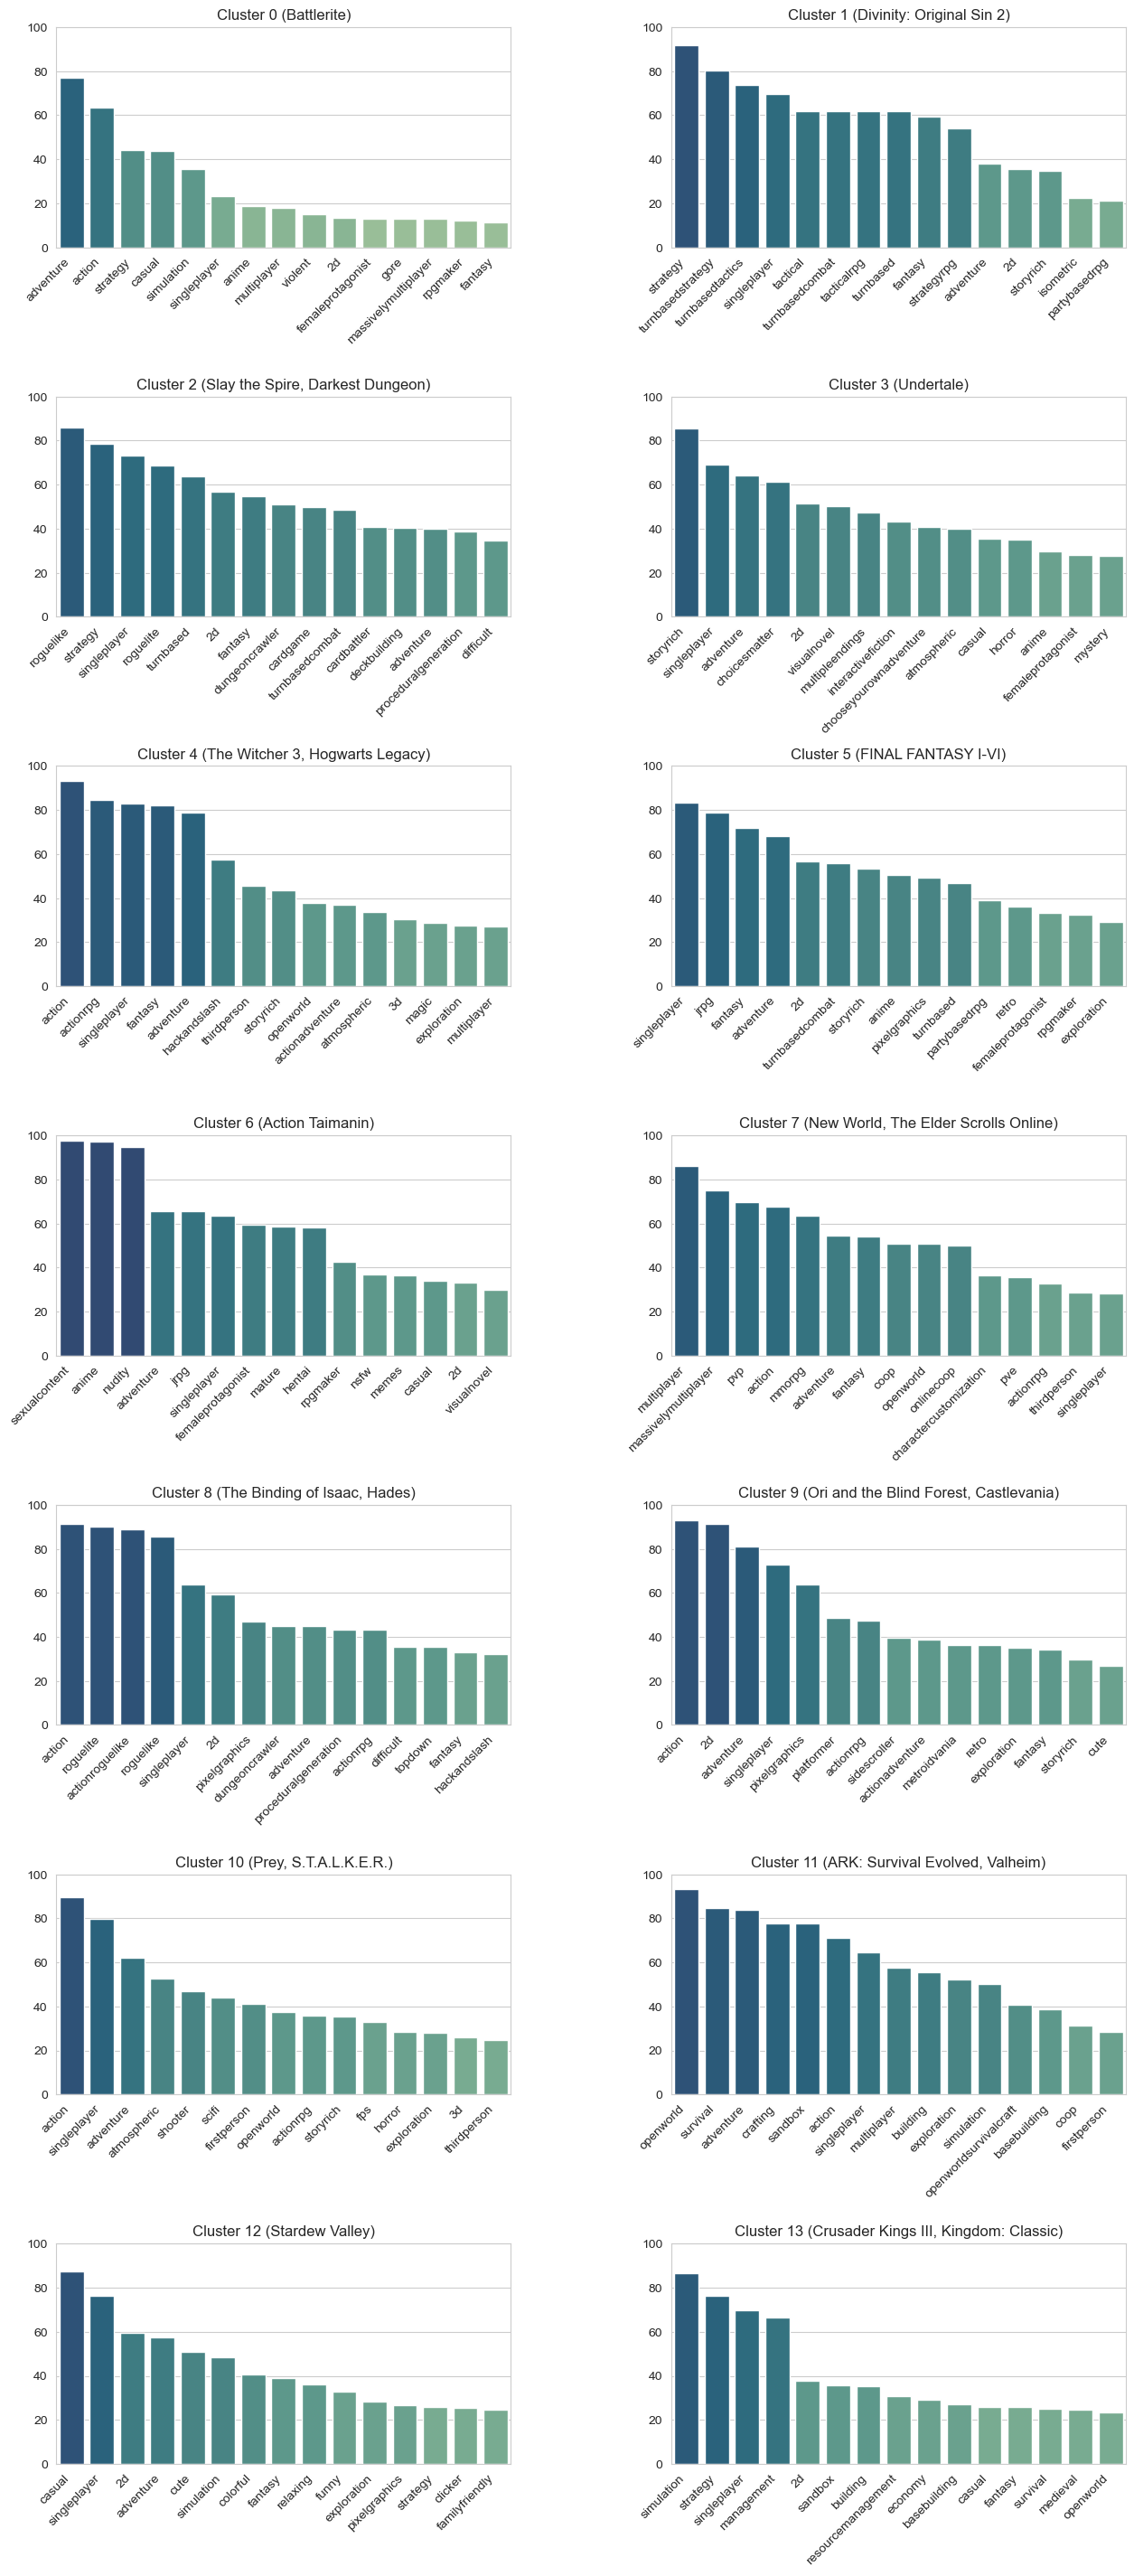

In [179]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 30))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    i_n = X[np.where(clusters == n)]
    N = len(X[i_n])
    
    tag_percentages = sum(i_n, 1) * 100 / N
    
    i_common = np.argsort(-tag_percentages)[0:15]
    common_tags_per = tag_percentages[i_common]
    common_tags = features[i_common]
    
    plot_df = pd.DataFrame({'x': common_tags, 'y': common_tags_per})
    plot_df['hue'] = plot_df.apply(lambda row: (row['y'] > 66 and 2) or (row['y'] > 33 and 1) or 0, axis = 1)
    
    palette = sns.color_palette("crest", 15)
    color_i = np.floor(common_tags_per*15/100).astype(np.int32) - 1
    sns.barplot(ax = axes[n//2, n%2], x = common_tags, y = common_tags_per, 
                palette = np.array(palette).take(color_i, axis = 0))
    
    axes[n//2, n%2].set_xticklabels(common_tags[0:15], rotation = 45, ha = 'right')
    axes[n//2, n%2].set_ylim(0, 100)
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')

    
plt.show()

## Trend Analysis

In [180]:
import datetime

In [181]:
games['release_date'] = games['release_year']*10000 + games['release_month']*100 + games['release_day']
games['release_date'] = pd.to_datetime(games['release_date'], format='%Y%m%d')
games['release_q'] = games['release_date'].dt.to_period('Q')

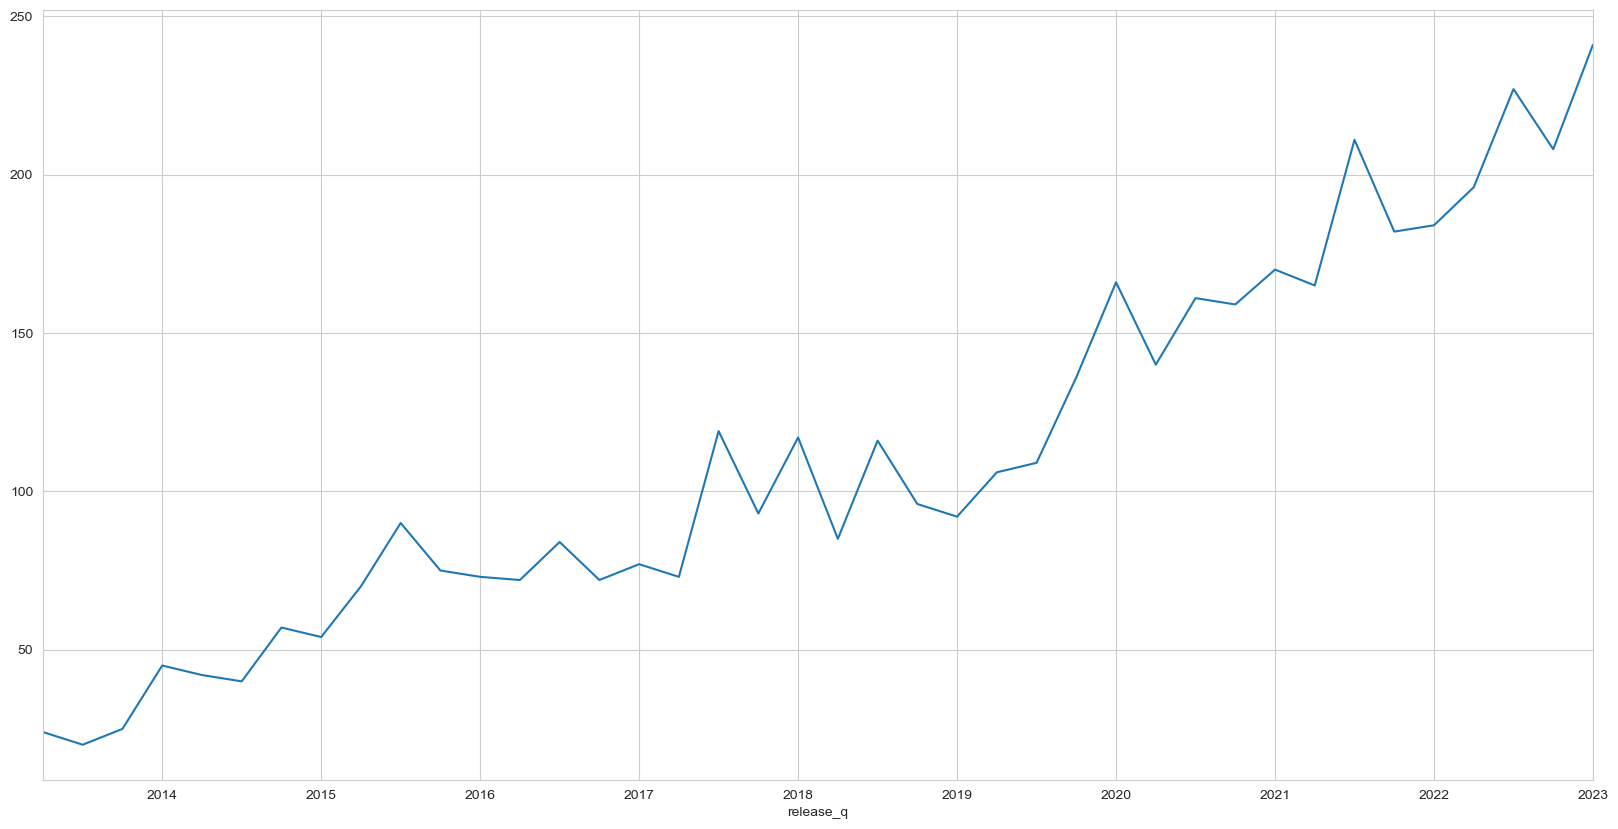

In [182]:
plot_df = games[('2013-04-01' <= games['release_date']) & (games['release_date'] < '2023-04-01')].groupby(['release_q','cluster']).agg(count=('cluster', 'count'))
plot_df = plot_df.unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df[['release_q', 'count']].groupby('release_q').sum().plot(legend = False, figsize = (20, 10));

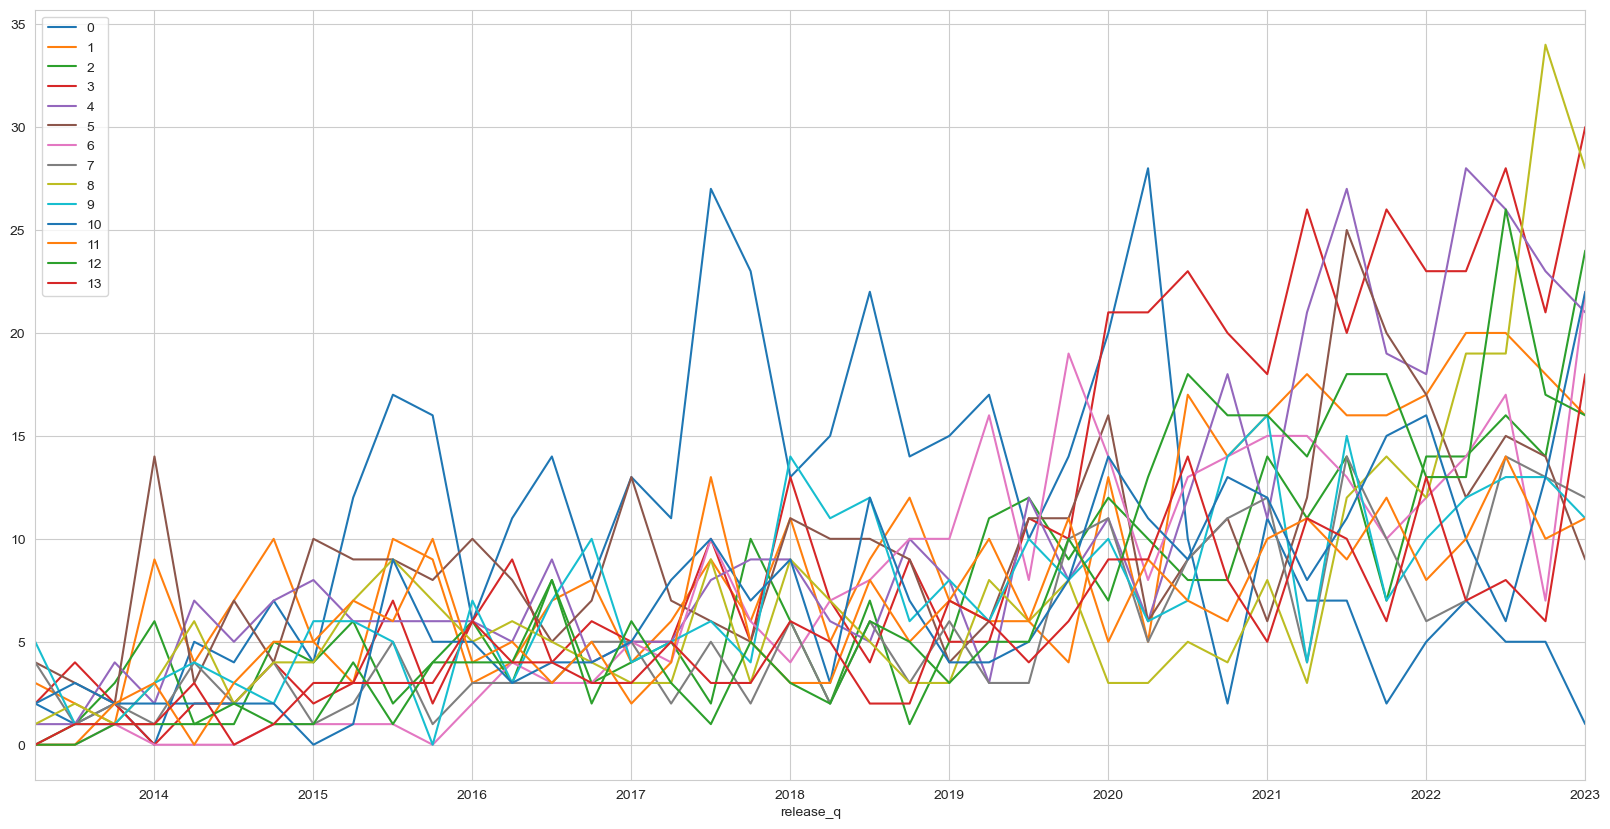

In [183]:
plot_df.set_index('release_q').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [184]:
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset

In [185]:
# Convert Quarters to actual dates (end date of each quarter) for plotting.
plot_df['release_q'] = plot_df['release_q'].dt.to_timestamp() 

In [186]:
quarters = (pd.date_range(pd.to_datetime('2013-04-01'), pd.to_datetime('2023-03-31') + pd.offsets.QuarterBegin(1), freq='Q').to_period('Q').
            strftime('%Y Q%q').tolist())

for i in range(len(quarters)):
    if 'Q1' in quarters[i]:
        quarters[i] = quarters[i].split(' ')[0]
    else:
        quarters[i] = ''

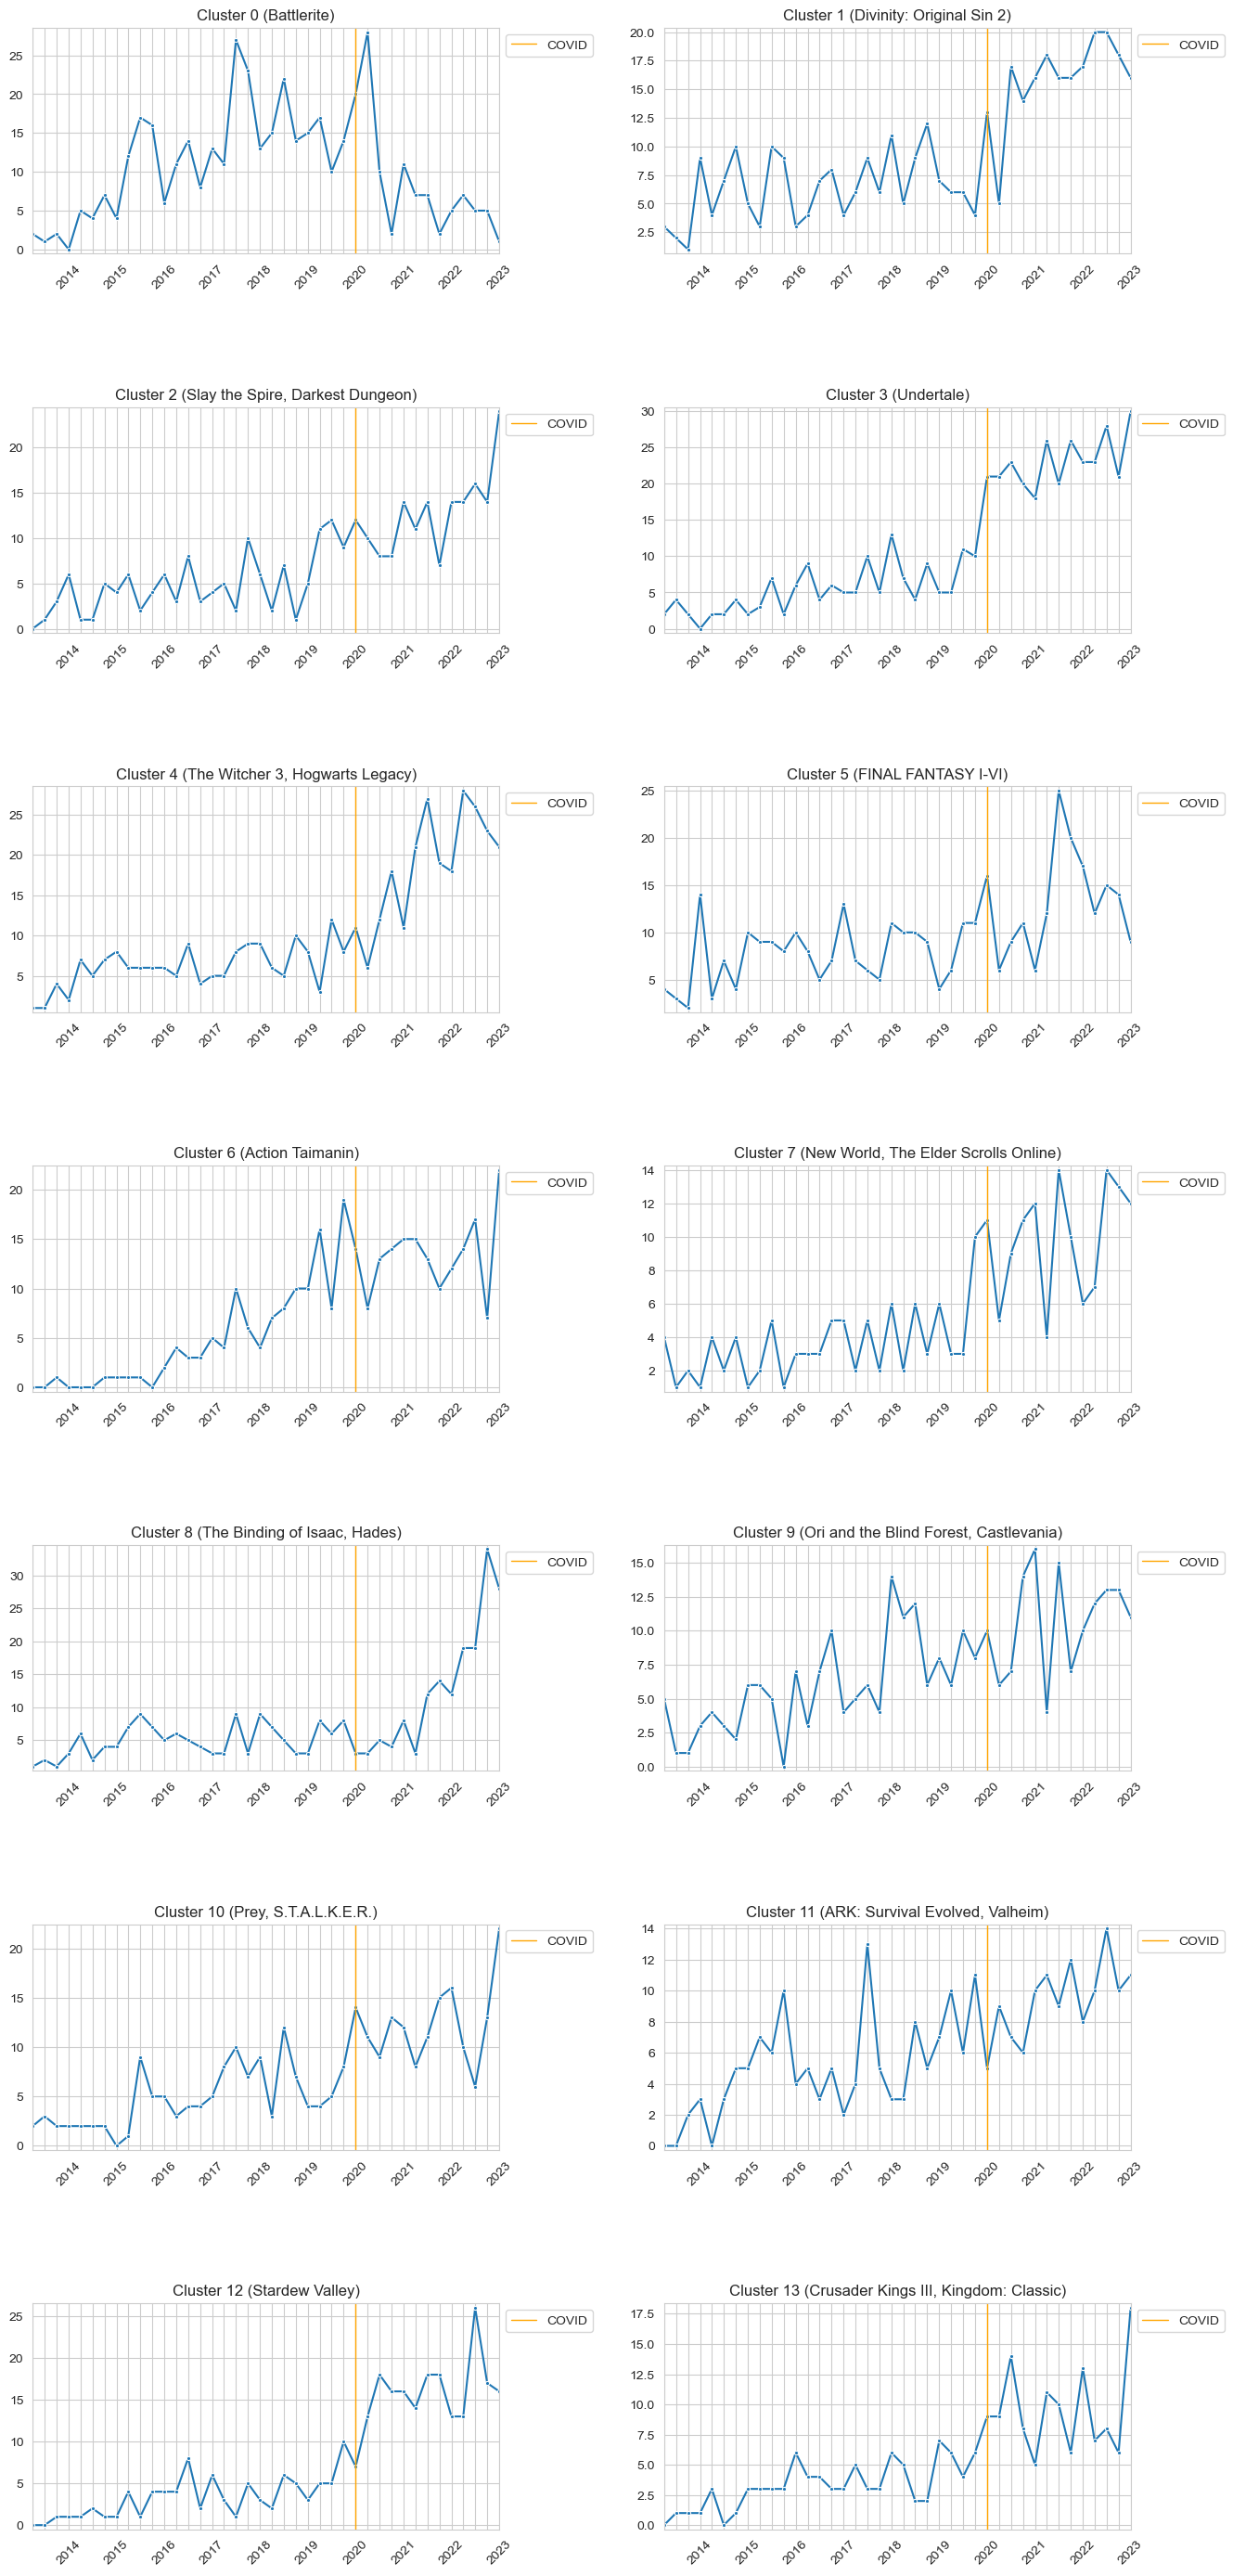

In [187]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 30))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_q', y = 'count', ax = axes[n//2, n%2], marker = '.');
    
    axes[n//2, n%2].axvline(x = pd.Timestamp(2020,1,1), lw = 1, ls = '-', color = 'orange', label = 'COVID')
    
    axes[n//2, n%2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[n//2, n%2].set_xticklabels(quarters, rotation = 45, ha = 'center')
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.02)
       
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')


if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()

In [188]:
plot_df = games.groupby(['release_year','cluster']).agg(count=('cluster', 'count')).unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df = plot_df[(2003 <= plot_df['release_year']) & (plot_df['release_year'] < 2023)]

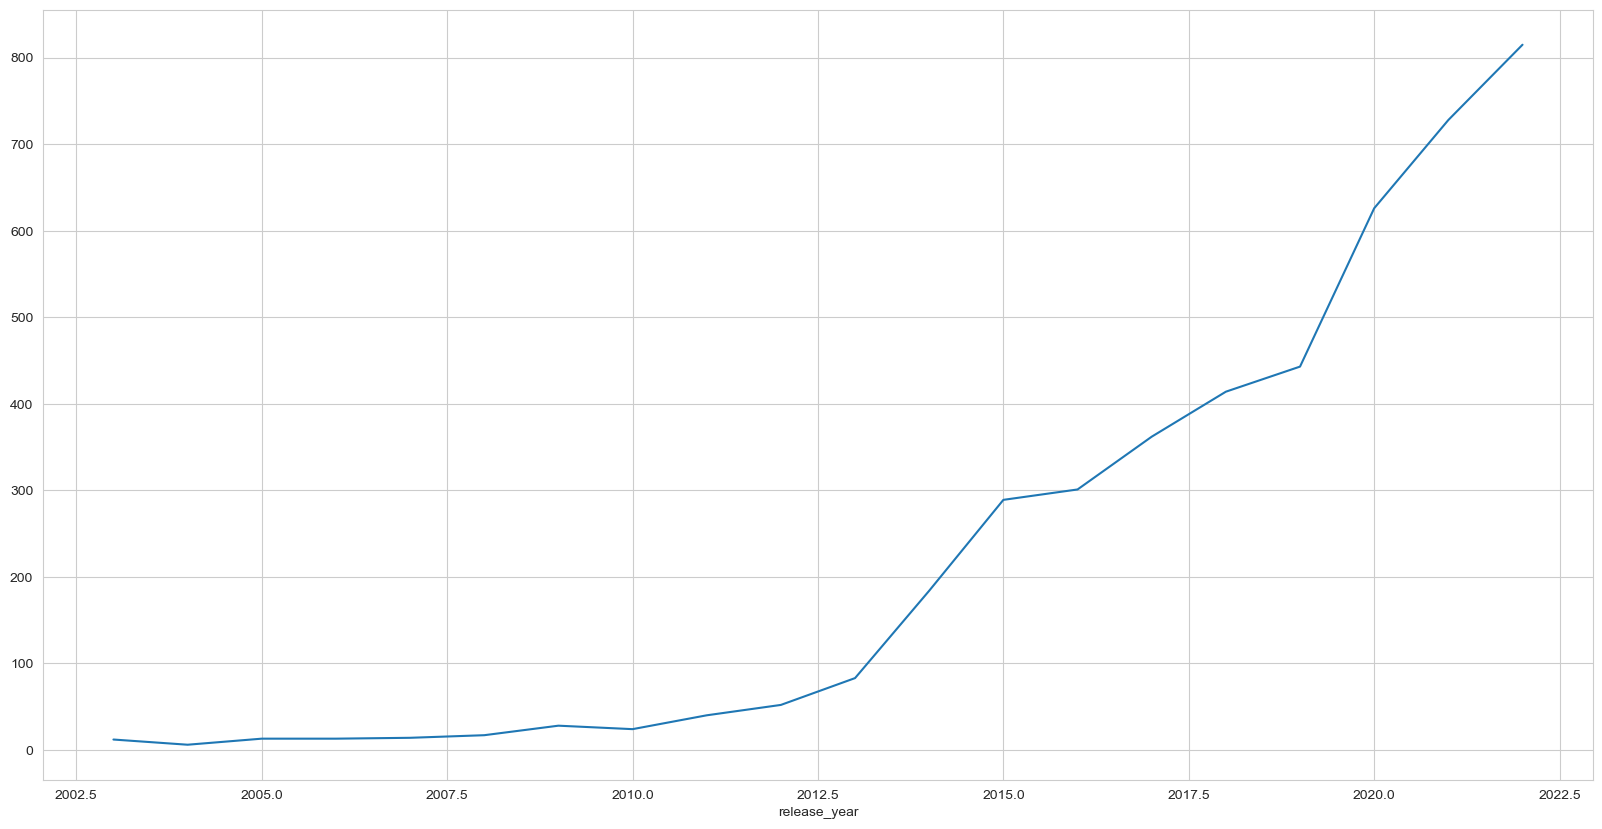

In [189]:
d = plot_df[['release_year', 'count']].groupby('release_year').sum().plot(figsize = (20, 10), legend = False);

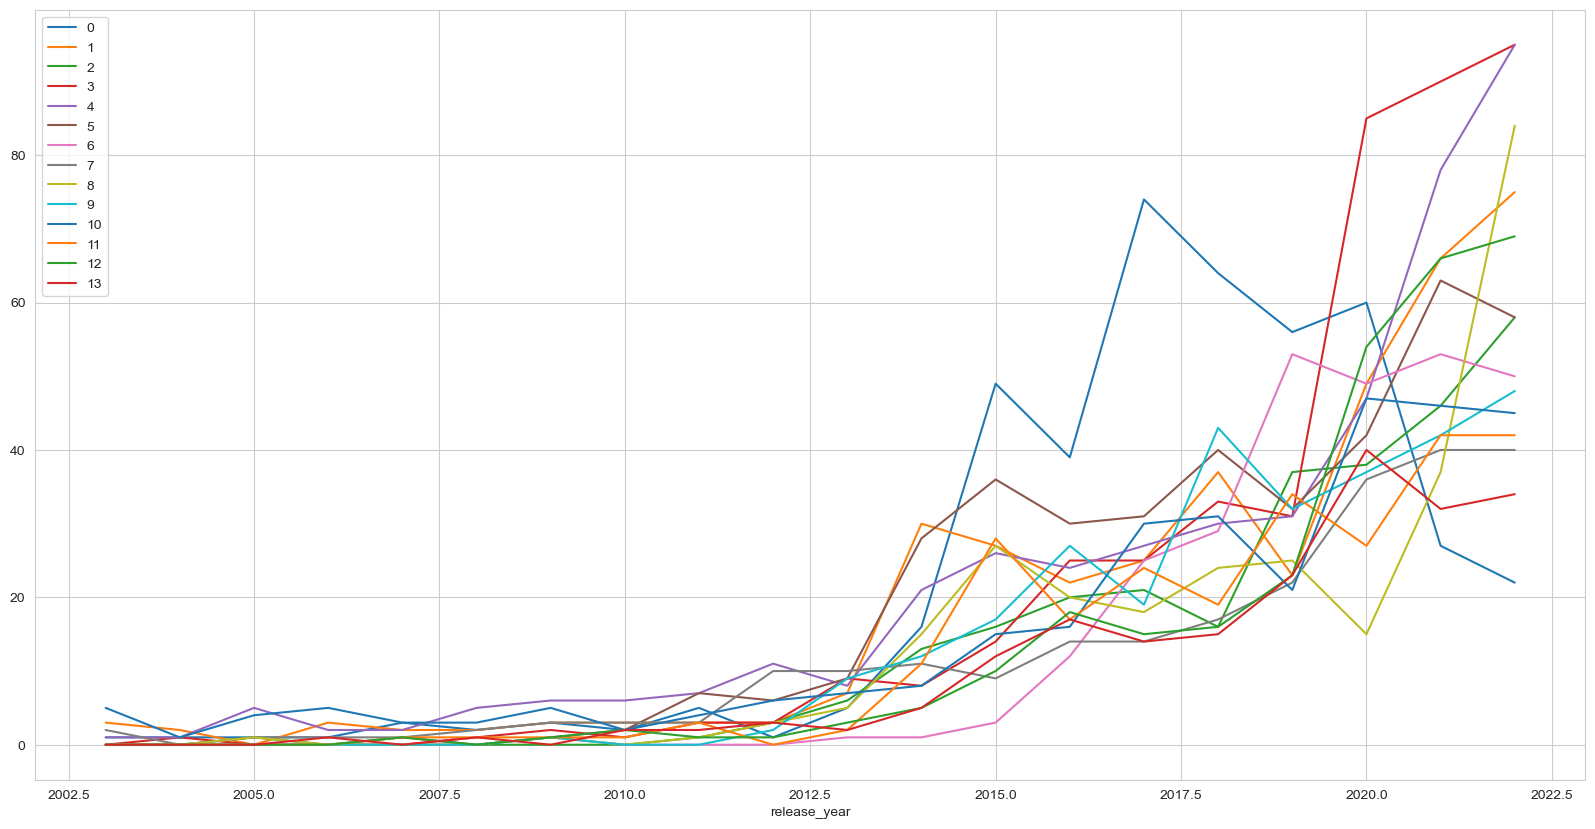

In [190]:
plot_df.set_index('release_year').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [191]:
from matplotlib.ticker import MaxNLocator

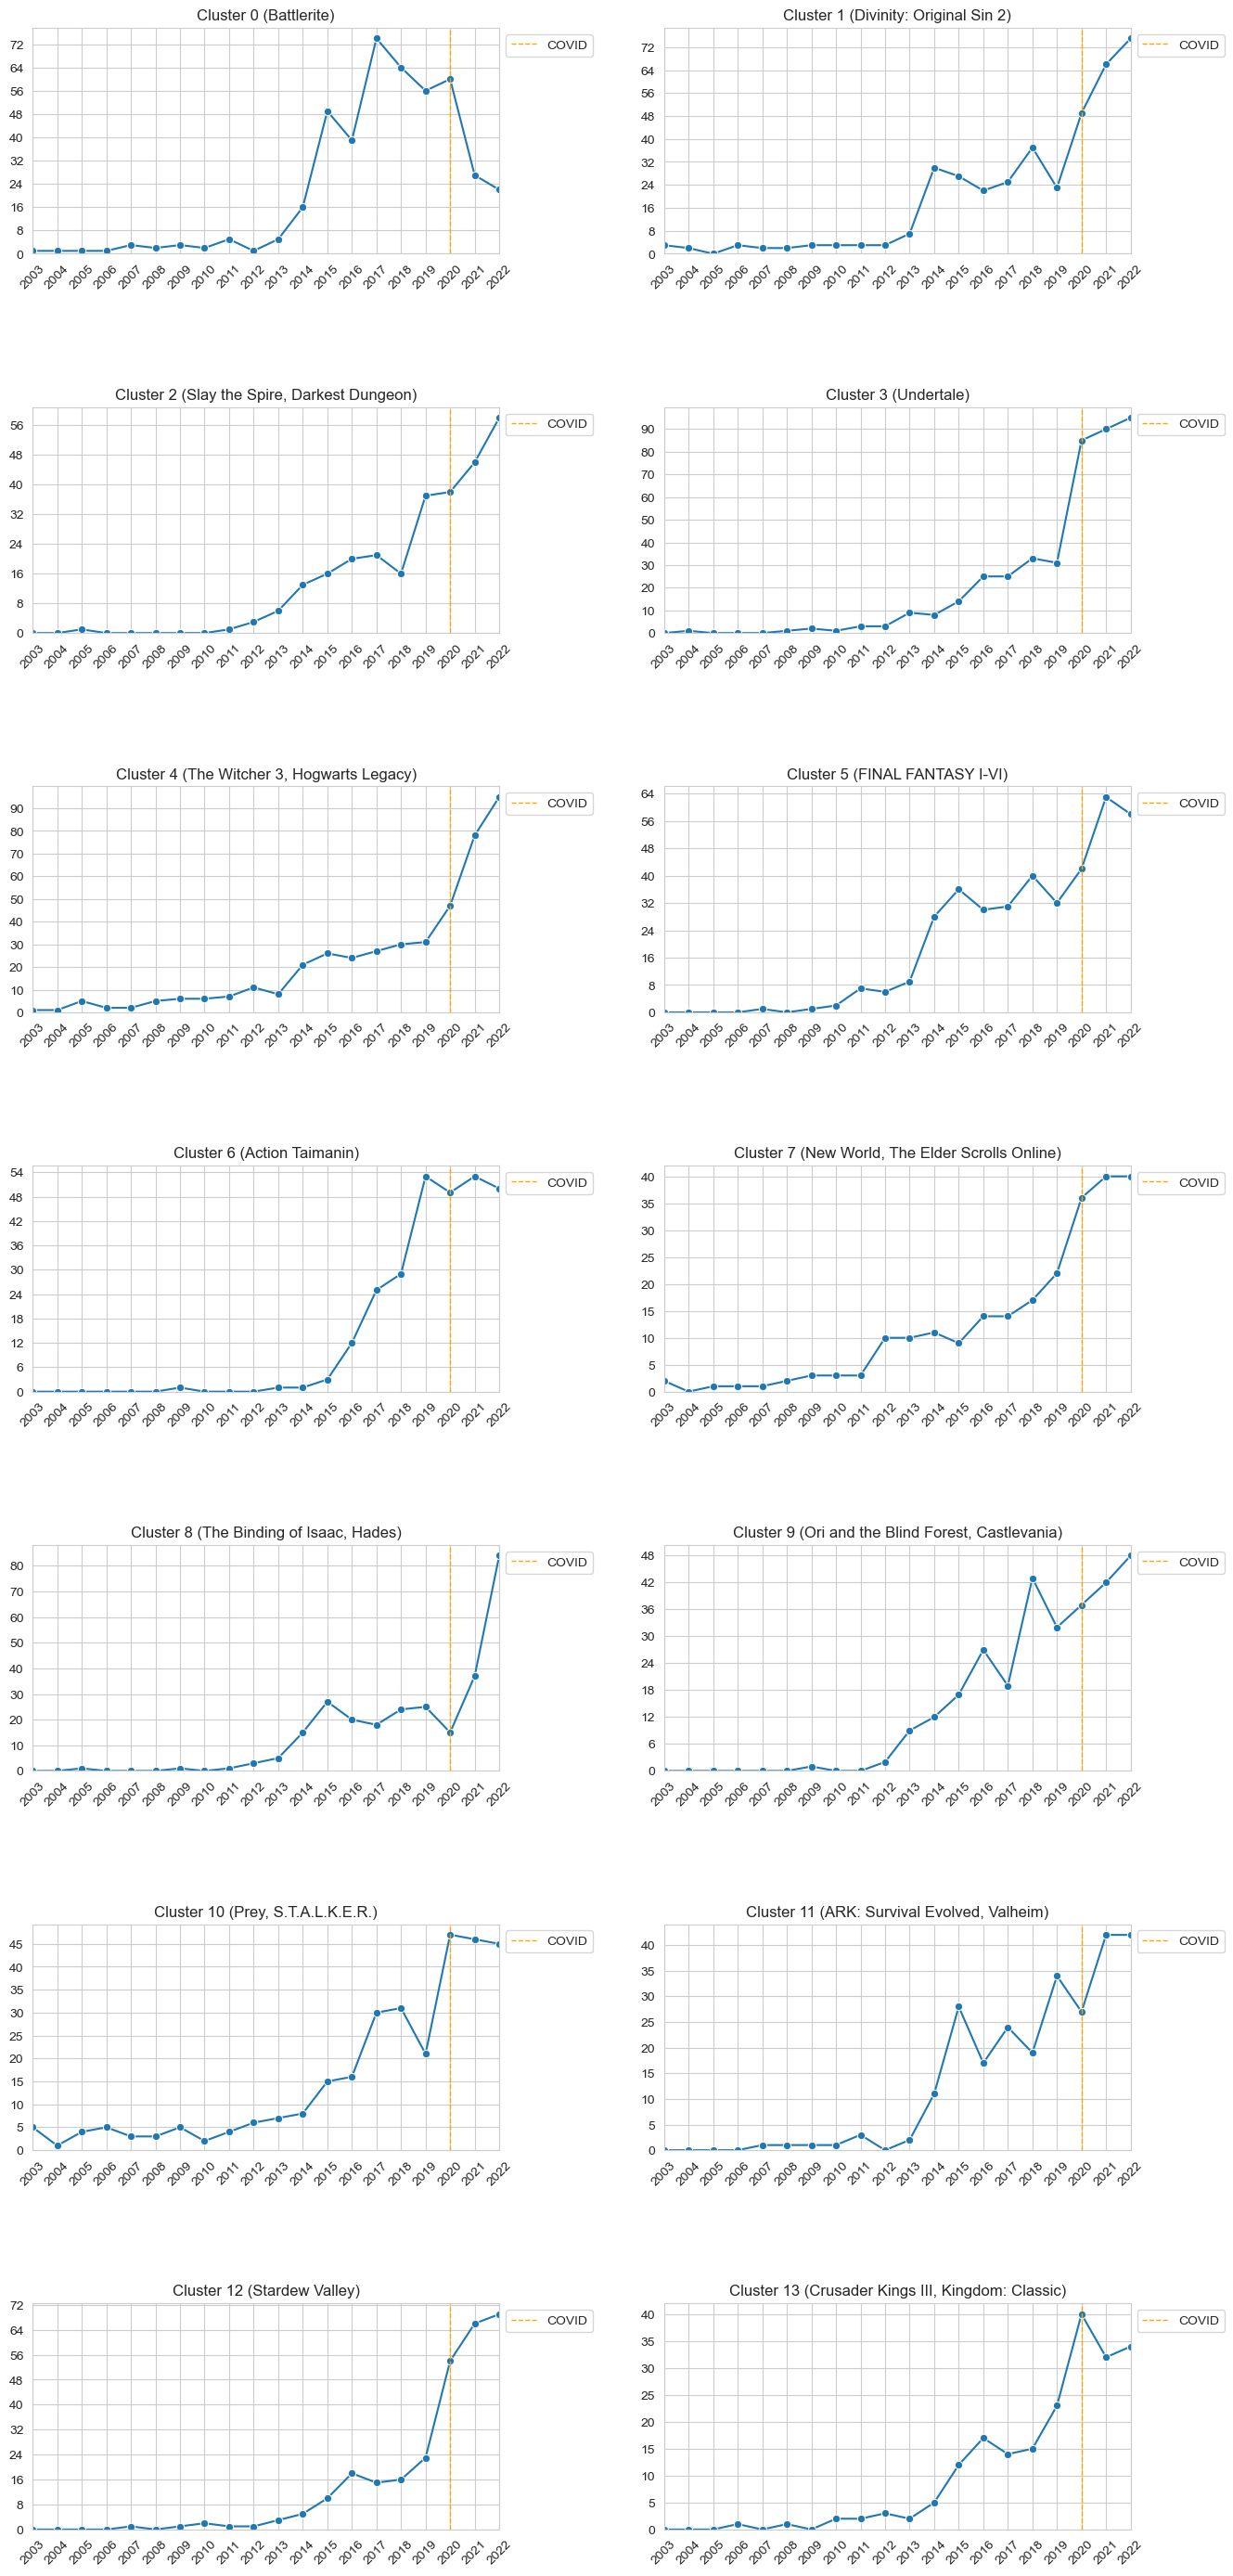

In [193]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 30))
fig.tight_layout(pad = 10.0)

years = [y for y in range(2003, 2023)]

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_year', y = 'count', ax = axes[n//2, n%2], marker = 'o');
    
    axes[n//2, n%2].axvline(x = 2020, lw = 1, ls = '--', color = 'orange', label = 'COVID')

    axes[n//2, n%2].set_xticks(years)
    axes[n//2, n%2].set_xticklabels(years, rotation = 45, ha = 'center')
    
    axes[n//2, n%2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[n//2, n%2].set_ylim(ymin=0)
    
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.2)
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()

In [197]:
games[(games['cluster'] == 0) & (games['num_reviews'] > 1000)].sort_values(by = 'silhouette_coeff', ascending = False)[['name', 'tags', 'silhouette_coeff','num_reviews']].head(50)

name  \
1344                        Midas Gold Plus   
1505                      VR Dungeon Knight   
1985                  汉匈决战/Han Xiongnu Wars   
4054               No-brainer Heroes 挂机吧！勇者   
1003                              Hero Zero   
1636                    Star Trek Timelines   
2756                      G2 Fighter / 基因特工   
1298                Touhou Blooming Chaos 2   
4057   Open World Game: the Open World Game   
4458                         Puzzle Pirates   
3975                          The Wind Road   
4456     Robin Hood: The Legend of Sherwood   
4683                                 Caster   
2320                                Onmyoji   
1723  侠客风云传前传(Tale of Wuxia:The Pre-Sequel)   
4264       Sang-Froid - Tales of Werewolves   
657                   Lords of the Realm II   
420   Navy Field 2 : Conqueror of the Ocean   
1552                Star Trek™: Bridge Crew   
1617                               Kingsway   
2941             Unsung Warriors - Prologue   
2645                  Touhou Big Big Battle   
521                           Time Clickers   
4637          SpellForce - Platinum Edition   
885                    侠客风云传(Tale of Wuxia)   
1422                                 Faeria   
47               BEARS, VODKA, BALALAIKA! 🐻   
1669                              MINDNIGHT   
2013                             Bit Heroes   
1936                   Yu-Gi-Oh! Duel Links   
3289                          PGA TOUR 2K23   
1942                             Battlerite   
2872                      Blade and Sorcery   
298                          Battle Islands   
371                           Town of Salem   
787                              ChilloutVR   
3914                         OMON Simulator   
688              Blood and Gold: Caribbean!   
387                      Forward to the Sky   
1848     Throne of Lies®: Medieval Politics   
2868           永冻之壳 The Shell of Permafrost   
1373         MadOut2 BigCityOnline [CLOSED]   
919                        Insanity Clicker   
2802                  DOKA 2 KISHKI EDITION   
2867                   Book of Yog Idle RPG   
85                             Lords Mobile   

                                                   tags  silhouette_coeff  \
1344  [simulation, adventure, singleplayer, strategy...          0.193774   
1505  [vr, coop, adventure, dungeoncrawler, roguelik...          0.164226   
1985  [sandbox, adventure, strategy, action, casual,...          0.163384   
4054  [simulation, adventure, idler, strategy, pixel...          0.155954   
1003  [2d, adventure, funny, strategy, clicker, casu...          0.152979   
1636  [adventure, strategy, singleplayer, space, act...          0.151313   
2756  [sexualcontent, coop, topdownshooter, gore, ad...          0.149037   
1298  [bullethell, shoot'emup, adventure, roguelike,...          0.148409   
4057  [2d, simulation, adventure, psychologicalhorro...          0.146665   
4458  [2d, coop, adventure, strategy, casual, puzzle...          0.138764   
3975  [adventure, singleplayer, action, swordplay, p...          0.136294   
4456  [adventure, isometric, strategy, singleplayer,...          0.133399   
4683  [thirdpersonshooter, adventure, thirdperson, s...          0.130919   
2320  [adventure, fantasy, turnbased, strategy, anim...          0.130213   
1723  [storyrich, adventure, crpg, turnbased, strate...          0.128365   
4264  [adventure, thirdperson, strategy, singleplaye...          0.127647   
657   [turnbased, strategy, classic, rts, medieval, ...          0.123214   
420   [simulation, singleplayer, strategy, action, o...          0.122244   
1552  [vr, coop, simulation, adventure, singleplayer...          0.120730   
1617  [simulation, adventure, roguelike, roguelite, ...          0.114207   
2941  [2d, coop, adventure, multiplayer, action, onl...          0.105453   
2645  [bullethell, simulation, adventure, pvp, rogue...          0.104769   
521   [simulation, adventure, point&click, idler, si...   